# Table of Contents

1. [Custom Plotting Functions](#functions)<br>
2. [Dataset Description](#dataset)<br>
3. [Data Preprocessing](#preprocessing)<br>
4. [Exploratory Data Analysis](#EDA)<br>
5. [Logistic Regression Model](#logreg)<br>
    5a. [Logistic Regression Observations](#logreg_obs)<br>
6. [Support Vector Classifier](#SVC)<br>
7. [Decision Tree Classifier](#dtree)<br>
8. [K Nearest Neighbors Classifier](#knn)<br>
9. [Naive Bayes Classifiers](#nbayes)<br>
    9a. [Naive Bayes without Scaling](#nbayes_unscaled)<br>
10. [Random Forest Classifier](#random_forest)<br>
    10a. [Random Forest Feature Importances](#random_forest_feats)<br>
11. [AdaBoost Classifier](#ada)<br>
12. [Stochastic Gradient Boosting Classifier](#sgb)<br>
13. [Neural Network](#nn) <br>
14. [Voting Classifiers](#voting)<br>
    14a. [Performance Summary of Prior Classifiers](#performance)<br>
    14b. [Voting Classifier with Unscaled Data](#voting_unscaled)<br>
    14c. [Voting Classifier with Scaled Data](#voting_scaled)<br>
    14d. [Voting Classifier with 3 Best Classifiers](#voting_3best)<br>



# Using Machine Learning to Identify Heart Disease 

[Heart Disease is the cause of 1 out of every 4 deaths in the United States](https://www.cdc.gov/heartdisease/facts.htm). Heart disease is a treatable condition, but we can only treat a condition if we can correctly diagnose the condition. 

In this notebook, I train and tune many of the most commonly used classifiers to survey their performance. In the process, I explore how different preprocessing steps and different sets of hyperparameters impact the performance of different classifiers and visual methods for exploring the hyperparameter spaces to get a better sense of how models react to slight variations in hyperparameters. 

In general, more training data will make models more accurate, but some data is very costly to acquire, so I've selected a smaller dataset to show how powerful these techniques are even with small datasets. This dataset didn't have any missing or illegal values so there was no need to delete observations or impute any values, but with sklearn's pipeline framework, adding imputation is a simple process. You can see examples of this pipeline framework below.

For each of the machine learning algorithms used in this notebook, I provide a short theoretical explanation of how the algorithm works, and use that understanding to guide the classifier tuning process.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
import os
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
# sklearn preprocessing and visualization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.tree import export_graphviz
import graphviz

In [3]:
# Linear Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE

In [4]:
# Base Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [5]:
# Ensembles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [6]:
# Neural Network
from sklearn.neural_network import MLPClassifier

In [7]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.float_format',lambda x: '%.5f' % x)
nb_seed = 1234

In [8]:
g_cmap = sns.light_palette('seagreen', n_colors=10, as_cmap=True)

## Custom Functions <a id="functions"></a>

In [9]:
RepeatedStratifiedKFold

In [256]:
def param_heat_mapper(ax_, df_, ind_col, val_col, col_col, base_clfname, cmap=g_cmap):
    '''Formats a heatmap of model performance given two hyperparameters
    
    Args:
        ax_:                a matplotlib axes object to plot to
        df_:                a Pandas DataFrame containing results from GridSearch in 
                              a tidy format where column names = parameter names
        ind_col_, col_col_: a string contaning the name of the feature to map
        val_col:            a string contining the name of the value column to map
        base_clfname:       a string containing a title prefix
    '''
    logit_piv = df_.pivot(index=ind_col, values=val_col, columns=col_col)
    title_ = base_clfname + ' Params: ' + ind_col + ' and ' + col_col
    with plt.style.context('seaborn-whitegrid'):
        sns.heatmap(logit_piv, linewidths=0.0, annot=True, fmt='0.3f',
                    ax=ax_, cmap=cmap, robust=True, annot_kws={'size':16})
        ax_.set_title(title_, fontsize=14)
        ax_.set_xlabel('Param: ' + col_col, fontsize=14)
        ax_.set_ylabel('Param: ' + ind_col, fontsize=14)

In [11]:
def train_test_param_map(x_var_, y_var_, map_df_):
    '''Prints two heatmaps showing model performance for different hyperparameter combinations.
    
    Args:
        x_var_, y_var_:   strings containing the names of the parameters to be mapped
        map_df_:          a Pandas DataFrame containing results from GridSearch in a 
                            tidy format where column names = parameter names
    '''
    with plt.style.context('seaborn-whitegrid'):
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(14,6))
        param_heat_mapper(ax[0], map_df_, y_var_, 'mean_train_score', x_var_, '[Training_Data]')
        param_heat_mapper(ax[1], map_df_, y_var_, 'mean_test_score', x_var_, '[Testing_Data]')

# Dataset Description <a id="dataset"></a>

This dataset was collected from the Cleveland Heart Disease Database and consists of 13 features for 270 patients as well as a labeled vector indicating whether specimen has heart disease or not. The 13 features (and their types) are listed and described below.

Features are described here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4441402/

Attribute Information: 
------------------------ 
1. age 
2. sex 
3. chest pain type (4 values) 
4. resting blood pressure 
5. serum cholestoral in mg/dl 
6. fasting blood sugar > 120 mg/dl 
7. resting electrocardiographic results (values 0,1,2) 
8. maximum heart rate achieved 
9. exercise induced angina 
10. oldpeak = ST depression induced by exercise relative to rest 
11. the slope of the peak exercise ST segment 
12. number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 

Attributes types 
----------------- 

* Real: 1,4,5,8,10,12 
* Ordered:11, 
* Binary: 2,6,9 
* Nominal:7,3,13 

In [12]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_values.csv')
X_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_train.head()

slope_of_peak_exercise_st_segment               thal  \
patient_id                                                         
0z64un                                      1             normal   
ryoo3j                                      2             normal   
yt1s1x                                      1             normal   
l2xjde                                      1  reversible_defect   
oyt4ek                                      3  reversible_defect   

            resting_blood_pressure  chest_pain_type  num_major_vessels  \
patient_id                                                               
0z64un                         128                2                  0   
ryoo3j                         110                3                  0   
yt1s1x                         125                4                  3   
l2xjde                         152                4                  0   
oyt4ek                         178                1                  0   

            fasting_blood_sugar_gt_120_mg_per_dl  resting_ekg_results  \
patient_id                                                              
0z64un                                         0                    2   
ryoo3j                                         0                    0   
yt1s1x                                         0                    2   
l2xjde                                         0                    0   
oyt4ek                                         0                    2   

            serum_cholesterol_mg_per_dl  oldpeak_eq_st_depression  sex  age  \
patient_id                                                                    
0z64un                              308                       0.0    1   45   
ryoo3j                              214                       1.6    0   54   
yt1s1x                              304                       0.0    1   77   
l2xjde                              223                       0.0    1   40   
oyt4ek                              270                       4.2    1   59   

            max_heart_rate_achieved  exercise_induced_angina  
patient_id                                                    
0z64un                          170                        0  
ryoo3j                          158                        0  
yt1s1x                          162                        1  
l2xjde                          181                        0  
oyt4ek                          145                        0

In [13]:
CSV_PATH = os.path.join('data', 'heart_disease', 'test_values.csv')
X_test = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
X_test.head()

slope_of_peak_exercise_st_segment               thal  \
patient_id                                                         
olalu7                                      2  reversible_defect   
z9n6mx                                      1             normal   
5k4413                                      2  reversible_defect   
mrg7q5                                      1             normal   
uki4do                                      2             normal   

            resting_blood_pressure  chest_pain_type  num_major_vessels  \
patient_id                                                               
olalu7                         170                1                  0   
z9n6mx                         138                4                  0   
5k4413                         120                4                  0   
mrg7q5                         102                3                  1   
uki4do                         138                4                  1   

            fasting_blood_sugar_gt_120_mg_per_dl  resting_ekg_results  \
patient_id                                                              
olalu7                                         0                    2   
z9n6mx                                         0                    0   
5k4413                                         0                    2   
mrg7q5                                         0                    0   
uki4do                                         0                    2   

            serum_cholesterol_mg_per_dl  oldpeak_eq_st_depression  sex  age  \
patient_id                                                                    
olalu7                              288                       0.2    1   59   
z9n6mx                              183                       1.4    0   35   
5k4413                              177                       2.5    1   43   
mrg7q5                              318                       0.0    0   60   
uki4do                              166                       3.6    1   61   

            max_heart_rate_achieved  exercise_induced_angina  
patient_id                                                    
olalu7                          159                        0  
z9n6mx                          182                        0  
5k4413                          120                        1  
mrg7q5                          160                        0  
uki4do                          125                        1

In [14]:
CSV_PATH = os.path.join('data', 'heart_disease', 'train_labels.csv')
y_train = pd.read_csv(CSV_PATH, encoding='latin1', index_col='patient_id') 
y_train.head()

heart_disease_present
patient_id                       
0z64un                          0
ryoo3j                          0
yt1s1x                          1
l2xjde                          1
oyt4ek                          0

From the info printout below, we see that all of the features except for 'thal' (Thalium heart scan observation), which is has the object (string) type. From the given feature information, we know that features
* **sex**
* **fasting_blood_sugar_gt_120_mg_per_dl**
* **exercise_induced_angina**

are binary categories and features

* **resting_ekg_results**
* **chest_pain_type**
* **thal**
* **slope_of_peak_exercise_st_segment**

are categorical features with more than 2 categories.

I'm using sklearn's machine learning libraries for my analysis, and sklearn is built on the numpy library which cannot correctly handle features of categorical data. To produce correct results, we'll have to make dummy variables for categorical features.

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null int64
thal                                    180 non-null object
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null int64
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null int64
resting_ekg_results                     180 non-null int64
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null int64
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 19.7+ KB


## Data Preprocessing <a id="preprocessing"></a>

In [16]:
categoricals = ['chest_pain_type', 'resting_ekg_results', 'thal', 
                'sex', 'fasting_blood_sugar_gt_120_mg_per_dl', 
                'exercise_induced_angina', 'slope_of_peak_exercise_st_segment']

def categorize_features(df, cats):
    df_cols = df.columns.tolist()
    for cat in cats:
        if cat in df_cols:
            df[cat] = df[cat].astype('category')
    return df

In [17]:
X_train = categorize_features(X_train, categoricals)
X_test = categorize_features(X_test, categoricals)

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 0z64un to 2nx10r
Data columns (total 13 columns):
slope_of_peak_exercise_st_segment       180 non-null category
thal                                    180 non-null category
resting_blood_pressure                  180 non-null int64
chest_pain_type                         180 non-null category
num_major_vessels                       180 non-null int64
fasting_blood_sugar_gt_120_mg_per_dl    180 non-null category
resting_ekg_results                     180 non-null category
serum_cholesterol_mg_per_dl             180 non-null int64
oldpeak_eq_st_depression                180 non-null float64
sex                                     180 non-null category
age                                     180 non-null int64
max_heart_rate_achieved                 180 non-null int64
exercise_induced_angina                 180 non-null category
dtypes: category(7), float64(1), int64(5)
memory usage: 11.8+ KB


**After changing the data types of the categorical features, we see that the memory usage dropped from 19.7 KB to 11.8 KB. While this is an extremely small dataset, on larger datasets this would produce a substantial improvement in runtime.**

### Nominal Categorical Types 

In [19]:
val_map = {1: 'typical_angina', 
           2: 'atypical_angina', 
           3: 'non_angina', 
           4: 'asymptotic_angina'}

print('Before mapping: {}'.format(X_train['chest_pain_type'].unique()))
X_train['chest_pain_type'] = X_train['chest_pain_type'].map(val_map)
print('After mapping: {}'.format(X_train['chest_pain_type'].unique()))

Before mapping: [2, 3, 4, 1]
Categories (4, int64): [2, 3, 4, 1]
After mapping: ['atypical_angina' 'non_angina' 'asymptotic_angina' 'typical_angina']


In [20]:
# Resting electrocardiographic results (names too long to map)
# 0: normal, 
# 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 
# 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria;
X_train['resting_ekg_results'].unique()

[2, 0, 1]
Categories (3, int64): [2, 0, 1]

In [21]:
# Thalium heart scan
X_train['thal'].unique()

[normal, reversible_defect, fixed_defect]
Categories (3, object): [normal, reversible_defect, fixed_defect]

In [22]:
val_map = {1: 'upsloping',
           2: 'flat',
           3: 'downsloping'}
print(X_train['slope_of_peak_exercise_st_segment'].unique())
X_train['slope_of_peak_exercise_st_segment'] = X_train['slope_of_peak_exercise_st_segment'].map(val_map)
print('After mapping: {}'.format(X_train['slope_of_peak_exercise_st_segment'].unique()))

[1, 2, 3]
Categories (3, int64): [1, 2, 3]
After mapping: ['upsloping' 'flat' 'downsloping']


### Binary Categorical Types

In [23]:
val_map = {0: 'female', 
           1: 'male'}
print('Before mapping: {}'.format(X_train['sex'].unique()))
X_train['sex'] = X_train['sex'].map(val_map)
print('After mapping: {}'.format(X_train['sex'].unique()))

Before mapping: [1, 0]
Categories (2, int64): [1, 0]
After mapping: ['male' 'female']


In [24]:
val_map = {0: 'false', 1: 'true'}
print('Before mapping: {} '.format(X_train['fasting_blood_sugar_gt_120_mg_per_dl'].unique()))
X_train['fasting_blood_sugar_gt_120_mg_per_dl'] = X_train['fasting_blood_sugar_gt_120_mg_per_dl'].map(val_map)
print('After mapping: {} '.format(X_train['fasting_blood_sugar_gt_120_mg_per_dl'].unique()))

Before mapping: [0, 1]
Categories (2, int64): [0, 1] 
After mapping: ['false' 'true'] 


In [25]:
val_map = {0: 'false', 1: 'true'}
print('Before mapping: {}'.format(X_train['exercise_induced_angina'].unique()))
X_train['exercise_induced_angina'] = X_train['exercise_induced_angina'].map(val_map)
print('After mapping: {}'.format(X_train['exercise_induced_angina'].unique()))

Before mapping: [0, 1]
Categories (2, int64): [0, 1]
After mapping: ['false' 'true']


## Exploratory Data Analysis <a id="EDA"></a>
Before creating dummy variables (and increasing the number of features), we should examine the data.

In [26]:
# Joining the labeled output with the features, for plotting
train_df = y_train.join(X_train)

In [27]:
train_df.head()

heart_disease_present slope_of_peak_exercise_st_segment  \
patient_id                                                            
0z64un                          0                         upsloping   
ryoo3j                          0                              flat   
yt1s1x                          1                         upsloping   
l2xjde                          1                         upsloping   
oyt4ek                          0                       downsloping   

                         thal  resting_blood_pressure    chest_pain_type  \
patient_id                                                                 
0z64un                 normal                     128    atypical_angina   
ryoo3j                 normal                     110         non_angina   
yt1s1x                 normal                     125  asymptotic_angina   
l2xjde      reversible_defect                     152  asymptotic_angina   
oyt4ek      reversible_defect                     178     typical_angina   

            num_major_vessels fasting_blood_sugar_gt_120_mg_per_dl  \
patient_id                                                           
0z64un                      0                                false   
ryoo3j                      0                                false   
yt1s1x                      3                                false   
l2xjde                      0                                false   
oyt4ek                      0                                false   

           resting_ekg_results  serum_cholesterol_mg_per_dl  \
patient_id                                                    
0z64un                       2                          308   
ryoo3j                       0                          214   
yt1s1x                       2                          304   
l2xjde                       0                          223   
oyt4ek                       2                          270   

            oldpeak_eq_st_depression     sex  age  max_heart_rate_achieved  \
patient_id                                                                   
0z64un                           0.0    male   45                      170   
ryoo3j                           1.6  female   54                      158   
yt1s1x                           0.0    male   77                      162   
l2xjde                           0.0    male   40                      181   
oyt4ek                           4.2    male   59                      145   

           exercise_induced_angina  
patient_id                          
0z64un                       false  
ryoo3j                       false  
yt1s1x                        true  
l2xjde                       false  
oyt4ek                       false

**As we'll be plotting some categorical features, I'll set an appropriate palette.**

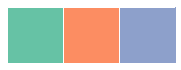

In [28]:
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
cat_palette = sns.color_palette(['#66c2a5', '#fc8d62', '#8da0cb'])
sns.palplot(cat_palette)

**From the frequency plot of heart disease below, we see that the two classes ('Heart Disease' and 'No Heart Disease') are approximately balanced, with 45% of observations having heart disease and the remaining population not having heart disease. **

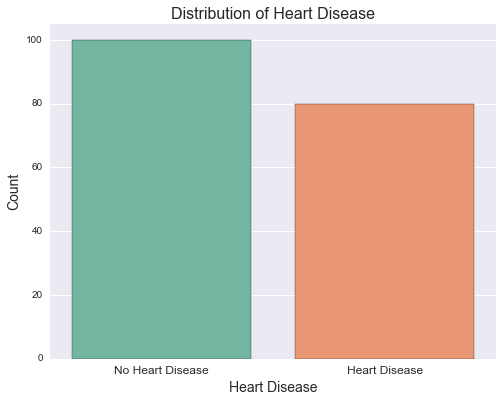

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train_df, x='heart_disease_present', palette=cat_palette, ax=ax)
ax.set_title('Distribution of Heart Disease', fontsize=16)
ax.set_xlabel('Heart Disease', fontsize=14)
ax.set_xticklabels(['No Heart Disease', 'Heart Disease'], fontsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_ylim([0,105])
plt.show()

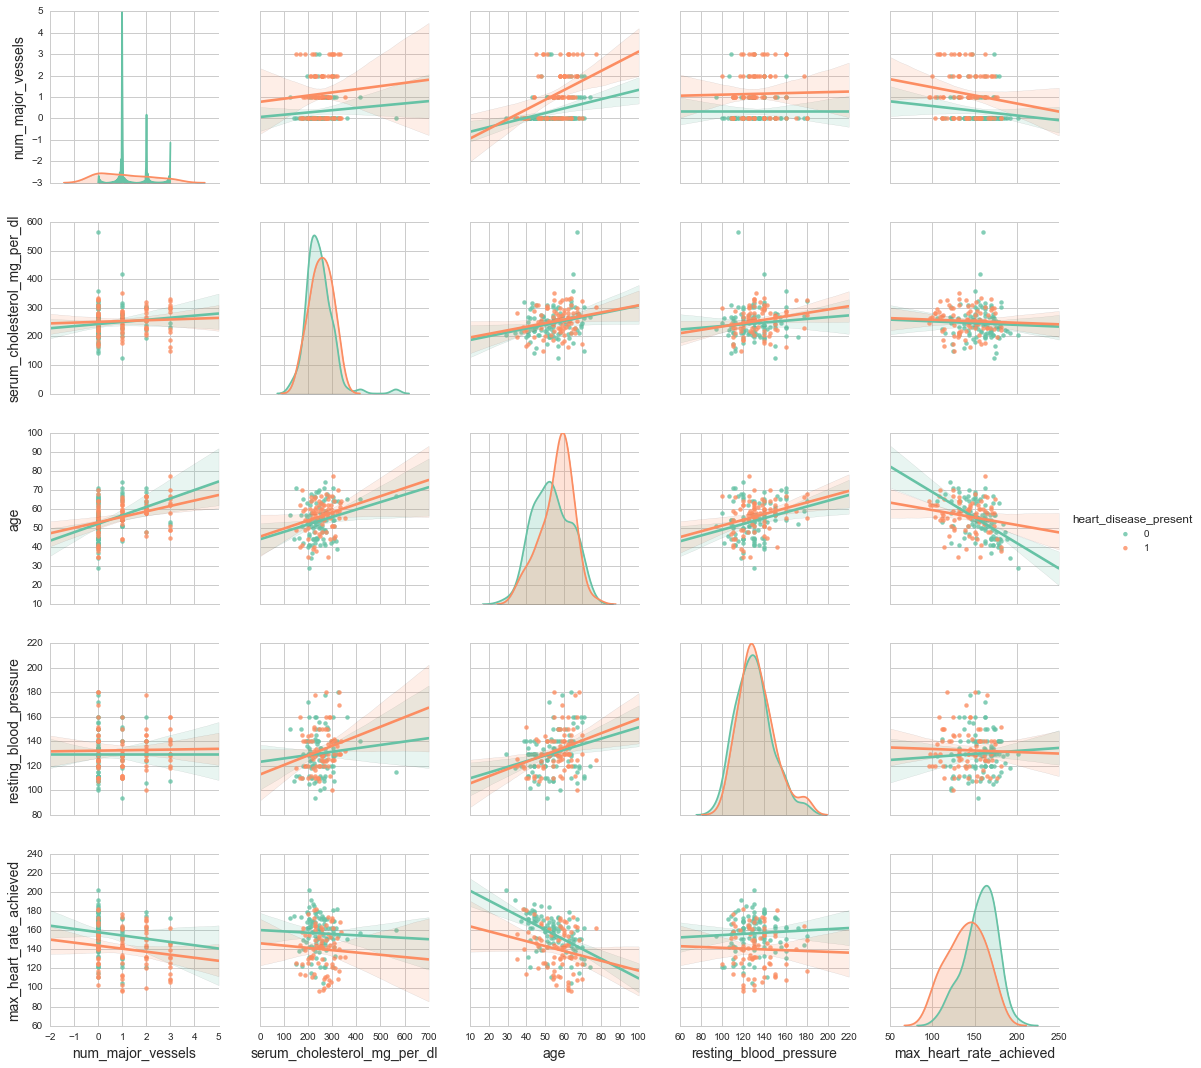

In [30]:
with sns.axes_style("whitegrid"):
    plt.rcParams["axes.labelsize"] = 14
    sns.pairplot(train_df, 
                 vars=['num_major_vessels', 'serum_cholesterol_mg_per_dl', 'age', 
                       'resting_blood_pressure', 'max_heart_rate_achieved'], 
                 kind='reg',
                 diag_kind='kde',
                 hue='heart_disease_present',
                 diag_kws={'shade':True},
                 palette=cat_palette, 
                 size=3)

**I've plotted all of the numerical features in the pairplot above, and I've colored the data by the 'heart_disease_present' label. The off-diagonal scatter plots include regression lines to show the trends for both populations relative to that plot's features, and the diagonal shows kernel density plots showing the rough distributions of the two populations.**

We can make a couple observations:
* From the plot of resting blood pressure as a function of age, we see that resting blood pressure tends to increase with age regardless of heart disease.
* From the plot of max heart rate as a function of age, we see that max heart rates are significantly lower for people without heart disease. 
* From the plot of 'serum cholesterol' (colloquially 'cholesterol levels'), we see that cholesterol levels increase with age regardless of heart disease.
* From the distribution plot of resting blood pressure, we see nearly perfect overlap of the distributions, indicating that feature probably won't be useful in discriminating between healthy and unhealthy cases.

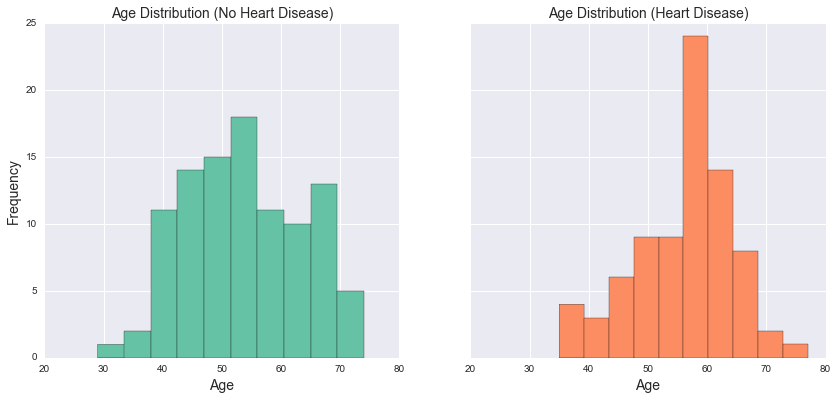

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(14,6))
train_df[train_df['heart_disease_present']==0]['age'].plot(kind='hist', color=colors[0], ax=ax[0])
train_df[train_df['heart_disease_present']==1]['age'].plot(kind='hist', color=colors[1], ax=ax[1])
ax[0].set_xlabel('Age', fontsize=14)
ax[1].set_xlabel('Age', fontsize=14)
ax[0].set_title('Age Distribution (No Heart Disease)', fontsize=14)
ax[1].set_title('Age Distribution (Heart Disease)', fontsize=14)
plt.show()

From the distributions of age plots, we see a fair amount of overlap, but the distribution of people with heart disease skews a little bit older than those without heart disease. This is intuitive.

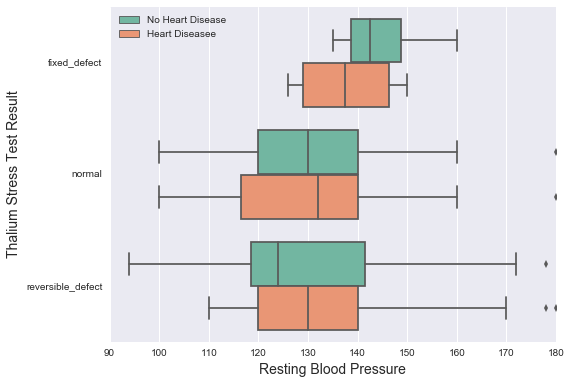

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=train_df, 
            y='thal', 
            x='resting_blood_pressure', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best', )
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Thalium Stress Test Result', fontsize=14)
plt.show()

In the boxplot above, we see that there is a lot of overlap of resting blood pressure range across all thalium stress test results, so resting blood pressure probably won't be a significant factor in detecting heart disease.

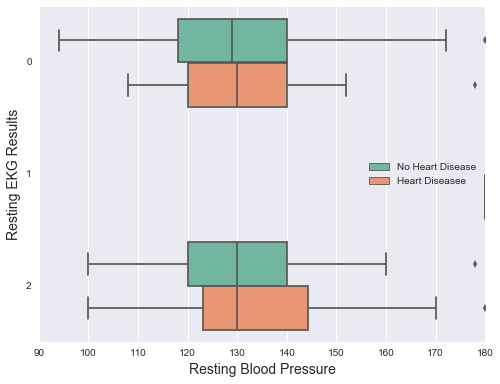

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=train_df, 
            y='resting_ekg_results', 
            x='resting_blood_pressure', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best', )
ax.set_xlabel('Resting Blood Pressure', fontsize=14)
ax.set_ylabel('Resting EKG Results', fontsize=14)
plt.show()

That's kind of strange, from that box plot, it appears there are very few examples of EKG result #1. We confirm that via the countplot below. As our only observations of this EKG type have heart disease, our classifier won't have any prior data to form an intuition about heart-disease free examples. Also, as we only have 1 example of this case in the training set, the cross validation process will leave it out of the cross-validation model trainings. In any case, our classifiers won't have enough data to learn how to handle this class.

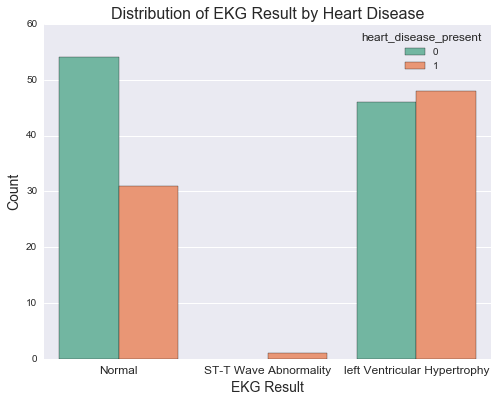

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train_df, x='resting_ekg_results', hue='heart_disease_present', palette=cat_palette, ax=ax)
ax.set_title('Distribution of EKG Result by Heart Disease', fontsize=16)
ax.set_xlabel('EKG Result', fontsize=14)
ax.set_xticklabels(['Normal', 'ST-T Wave Abnormality', 'left Ventricular Hypertrophy'], fontsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_ylim([0,60])
plt.show()

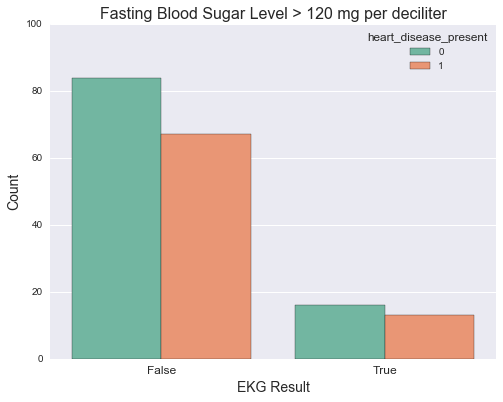

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=train_df, x='fasting_blood_sugar_gt_120_mg_per_dl', hue='heart_disease_present', palette=cat_palette, ax=ax)
ax.set_title('Fasting Blood Sugar Level > 120 mg per deciliter', fontsize=16)
ax.set_xlabel('EKG Result', fontsize=14)
ax.set_xticklabels(['False', 'True'], fontsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_ylim([0,100])
plt.show()

Looking at the histogram of fasting blood sugar levels relative to 120 mg per deciliter, we see that the relative distributions are approximately equal. There may be other interactions with other features that allow models to use this value to discriminate between those with and without heart disease, but at this point, this evidence implies fasting blood sugar levels aren't a significant predictor of heart disease.

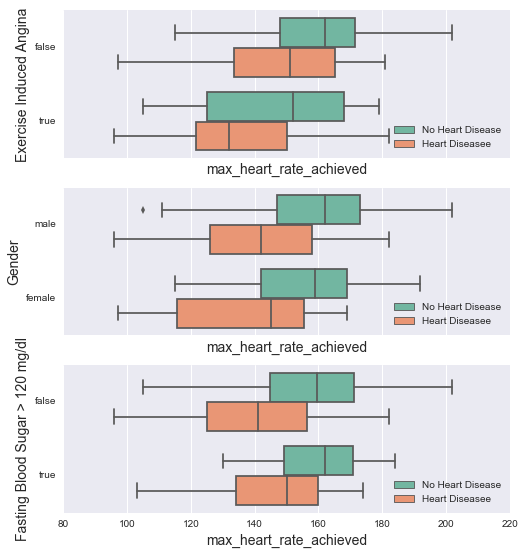

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,9))
sns.boxplot(data=train_df, 
            y='exercise_induced_angina', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[0])
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[2].set_xlabel('Max Heart Rate Achieved [bpm]', fontsize=14)
ax[0].set_ylabel('Exercise Induced Angina', fontsize=14)

sns.boxplot(data=train_df, 
            y='sex', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[1])
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[1].set_ylabel('Gender', fontsize=14)

sns.boxplot(data=train_df, 
            y='fasting_blood_sugar_gt_120_mg_per_dl', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[2])
handles, _ = ax[2].get_legend_handles_labels()
ax[2].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[2].set_ylabel('Fasting Blood Sugar > 120 mg/dl', fontsize=14)
plt.show()

Looking at the boxplots above we see for all three y-axis features, people with heart disease tend to achieve a lower max heart rate than those without heart disease. This makes intuitive sense, as max heart rate is an intuitive indicator of cardiac performance, and it makes sense that heart disease would reduce performance. In the boxplot broken down by gender, from the interquartile ranges, we see that healthy men and women achieve similar max heart rates, and for both genders, there is relatively little overlap between healthy and unhealthy populations.

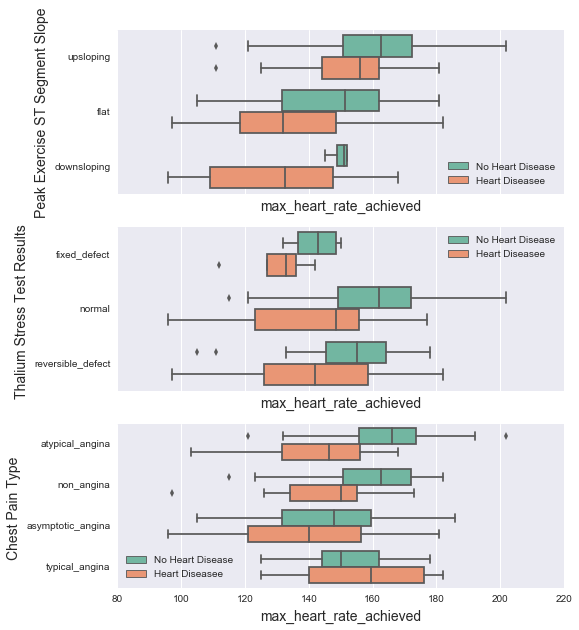

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,10))
sns.boxplot(data=train_df, 
            y='slope_of_peak_exercise_st_segment', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[0])
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[2].set_xlabel('Max Heart Rate Achieved [bpm]', fontsize=14)
ax[0].set_ylabel('Peak Exercise ST Segment Slope', fontsize=14)

sns.boxplot(data=train_df, 
            y='thal', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[1])
handles, _ = ax[1].get_legend_handles_labels()
ax[1].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[1].set_ylabel('Thalium Stress Test Results ', fontsize=14)

sns.boxplot(data=train_df, 
            y='chest_pain_type', 
            x='max_heart_rate_achieved', 
            hue='heart_disease_present', 
            palette=cat_palette,
            ax=ax[2])
handles, _ = ax[2].get_legend_handles_labels()
ax[2].legend(handles, ['No Heart Disease','Heart Diseasee'], loc='best')
ax[2].set_ylabel('Chest Pain Type ', fontsize=14)
plt.show()

From the peak exercise ST segment slope, we see for downsloping cases that there's no overlap between interquartile ranges, so these should be easy cases to classify. There's moderate overlap between healthy and unhealthy populatons for flat and upsloping cases, so max heart rate will be less useful in separating healthy and unhealthy cases.

From the thalium stress test boxplot, we see that the median max heart rate for people with heart disease is less than the lower quartile max heart rate for people without disease. We also see for fixed_defect cases that there is no overlap between the interquartile ranges, so these should be easy samples for classifiers to distinguish. The thalium stress test features (relative to max heart rate) are probably going to be significant factors in classifying new examples.

From the chest pain type boxplot, we see for atypical angina and non angina cases, there's almost no overlap between the interquartile ranges. These cases will probably be easy to classify.

In [38]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Models <a id="models"></a>

Now that we've preprocessed our data and reformulated it to be suitable with sklearn's numpy framework, and explored the data to develop an intuition about the data, let's start building classifiers! 

## Logistic Regression <a id="logreg"></a>

In [61]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=30, return_train_score=True)
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))

Best CV params {'C': 0.1, 'penalty': 'l2'}
Total number of features: 18
Number of selected features: 18


In [62]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_C'], 
                    'penalty': grid_clf.cv_results_['param_penalty']} 

#### Hyperparameter Performance

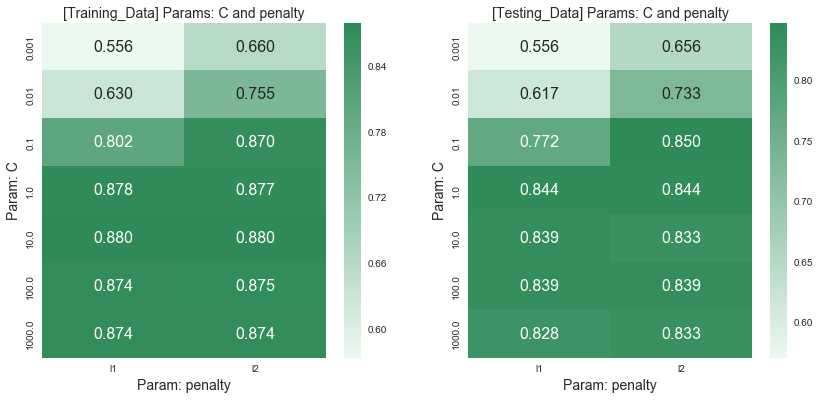

In [63]:
train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

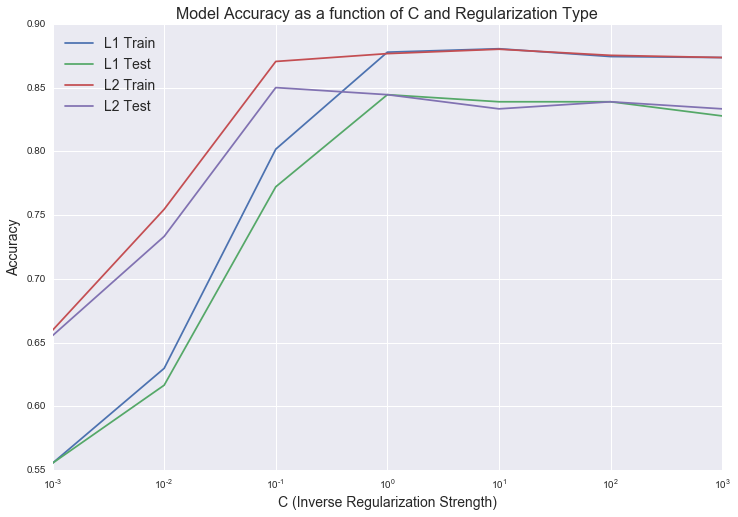

In [66]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Accuracy as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [67]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 85.000%
Best parameter(s): {'C': 0.1, 'penalty': 'l2'}


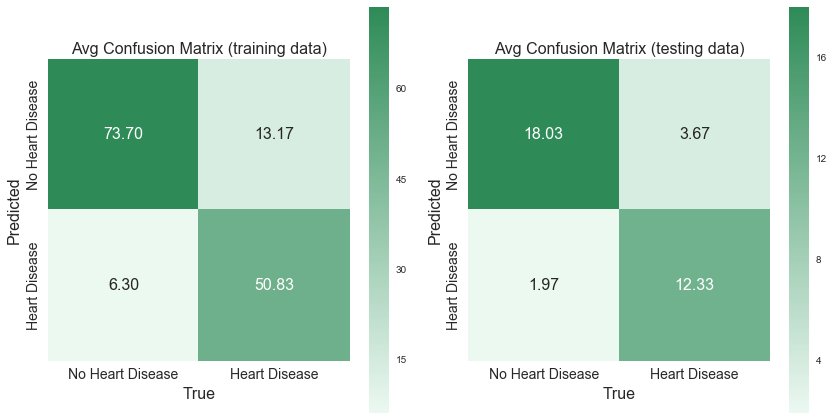

In [68]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Logistic Regression Observations <a id="logreg_obs"></a>
From the plot and printout above, we see that the highest accuracy is achieved when the parameter $C$ is set to $0.1$ and the penalty parameter is set to 'l2' (aka **Ridge Regression**). However, accuracy is a measure of how well **all** cases were classified, and the 2 different kinds of misclassifications (labeling a healthy person as unhealthy, and labeling an unhealthy person as healthy) are not equally bad. It's definitely worse to label someone as healthy if they actually have heart disease, as their heart disease would go untreated, and they may continue with an unhealthy diet or pursue dangerous activity levels. In terms of classification metrics, that kind of prediction mistake is a **False Negative**. The alternative mistake (a **False Positive**) is to label someone as unhealthy when they are actually healthy, which would lead to someone unnecessarily changing their diet and lifestyle, which would be unpleasant, but not potentially lethal, as in the other case. From the **confusion matrices** above, we see that the most 'accurate' model tends to make the worse kind of mistake.

We should try to build a model again, but we should use a scoring metric that takes the cost of mistakes into account. 

In [69]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=30, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print('Total number of features: {}'.format(coefs.size))
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'C': 1, 'penalty': 'l1'}
Total number of features: 18
Number of selected features: 16
Average Accuracy of the best model: 0.7962962962962962


This time, the number of significant features is less than the total number of features, so I'll recursively eliminate unimportant features.

In [70]:
logreg = LogisticRegression(C=1, penalty='l1')
logreg_rfe = RFE(logreg, 13)
logreg_rfe.fit(X_train, y_train.values.reshape((len(y_train), )))
print(logreg_rfe.support_)
print(logreg_rfe.ranking_)

[False  True False  True  True False  True  True  True  True  True  True
  True False False  True  True  True]
[3 1 4 1 1 2 1 1 1 1 1 1 1 5 6 1 1 1]


In [71]:
X_train.loc[:,logreg_rfe.support_].columns.tolist()

['num_major_vessels',
 'oldpeak_eq_st_depression',
 'age',
 'slope_of_peak_exercise_st_segment_flat',
 'slope_of_peak_exercise_st_segment_upsloping',
 'thal_normal',
 'thal_reversible_defect',
 'chest_pain_type_atypical_angina',
 'chest_pain_type_non_angina',
 'chest_pain_type_typical_angina',
 'resting_ekg_results_2',
 'sex_male',
 'exercise_induced_angina_true']

In [74]:
logreg = LogisticRegression()
parameters = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(logreg, parameters, cv=30, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train.loc[:,logreg_rfe.support_], y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print('Total number of features: {}'.format(coefs.size))
print('Number of selected features: {}'.format(np.count_nonzero(coefs)))
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'C': 0.1, 'penalty': 'l2'}
Total number of features: 13
Number of selected features: 13
Average Accuracy of the best model: 0.7953703703703703


Ok, so we can see that the l1 logistic regression (aka **Lasso Regression**) was smart enough to assign 0 importance to features below the significance threshold.  

In [75]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_C'], 
                    'penalty': grid_clf.cv_results_['param_penalty']} 

#### Hyperparameter Performance

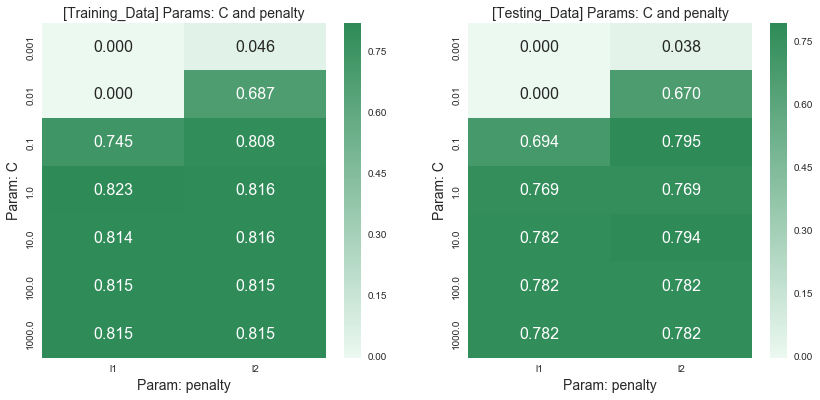

In [76]:
train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

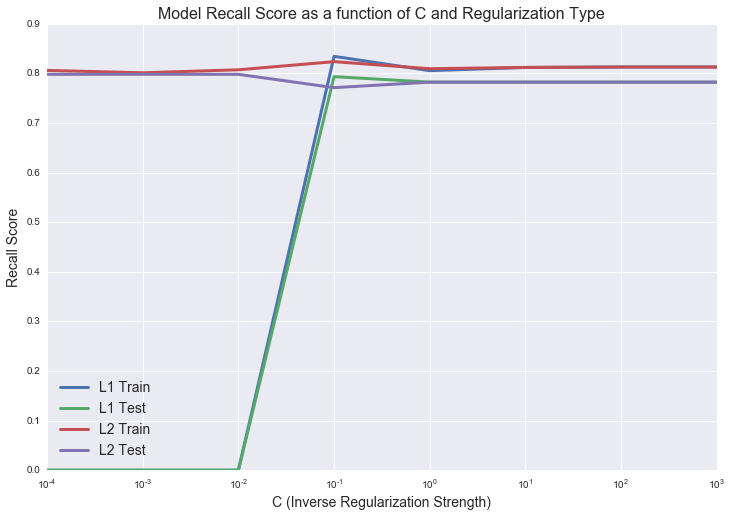

In [139]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train', linewidth=3)
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test', linewidth=3)
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train', linewidth=3)
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Recall Score as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [79]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 79.537%
Best parameter(s): {'C': 0.1, 'penalty': 'l2'}


The confusion matrices directly below as well as the confusion matrices a bit further up were made by fitting classifiers with 30 different slices of the data and generating a confusion matrix for each data slice. The confusion matrices below used a classifier with parameters {$C = 1$, penalty $= \text{L2}$}, only used the 13 features that the recursive feature elimination found to be significant, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.30$ unhealthy people as being healthy, which is slightly better than the above model, which labeled $3.67$ unhealthy people as healthy, and this model labeled $1.93$ healthy people as unhealthy while the above model labeled $1.97$ healthy people as unhealthy.

This is an improvement.

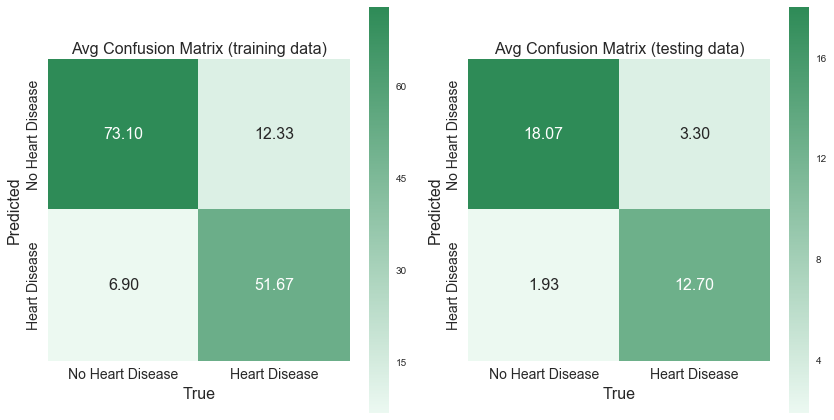

In [80]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train.loc[:,logreg_rfe.support_],
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Normalizing Feature Values (Pipeline Example)

In the previous models, I didn't normalize the data to a consistent scale. This means features that had a very small unit size may have a high nominal value, which can mislead some learning algorithms into overestimating the significance of that feature. In this model, I'll try scaling the features and I'll revert to using the full set of training features. 

In [81]:
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]
pipeline = Pipeline(steps)
parameters = {'logreg__penalty':['l1','l2'],
              'logreg__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
logreg_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall')
logreg_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

print("Best CV params", logreg_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(logreg_gs.best_score_))

Best CV params {'logreg__C': 0.0001, 'logreg__penalty': 'l2'}
Average Accuracy of the best model: 0.798148148148148


In [82]:
grid_clf = logreg_gs
logreg_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'C': grid_clf.cv_results_['param_logreg__C'], 
                    'penalty': grid_clf.cv_results_['param_logreg__penalty']} 

#### Hyperparameter Performance

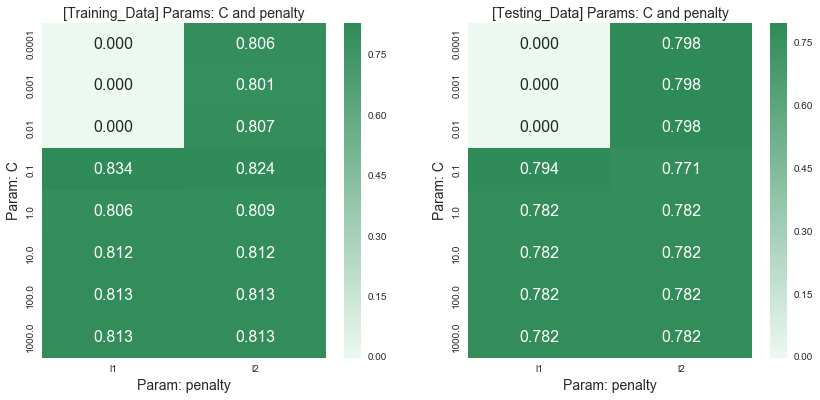

In [83]:
train_test_param_map(x_var_='penalty', y_var_='C', map_df_=pd.DataFrame(logreg_grid_dict))

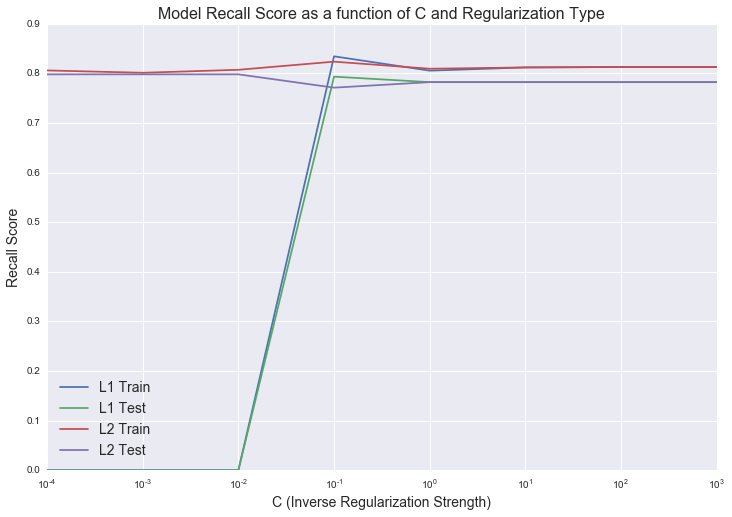

In [85]:
map_df = pd.DataFrame(logreg_grid_dict)
x_var = map_df[map_df['penalty'] == 'l1']['C']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_train_score'], label='L1 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l1']['mean_test_score'], label='L1 Test')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_train_score'], label='L2 Train')
ax.semilogx(x_var, map_df[map_df['penalty'] == 'l2']['mean_test_score'], label='L2 Test')
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Recall Score as a function of C and Regularization Type', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [86]:
print('Best accuracy: {:0.3f}%'.format(logreg_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(logreg_gs.best_params_))

Best accuracy: 79.815%
Best parameter(s): {'logreg__C': 0.0001, 'logreg__penalty': 'l2'}


The confusion matrices below used a classifier with parameters {$C = 0.0001$, penalty $= \text{L2}$}, used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.17$ unhealthy people as being healthy, which is slightly better than both of the above models, which labeled $3.67$ and $3.30$ unhealthy people as healthy, but this model labeled $4.00$ healthy people as unhealthy which is more than both of the previous models.

Considering the differing costs of mistakes, I'd say this is yet another improvement.

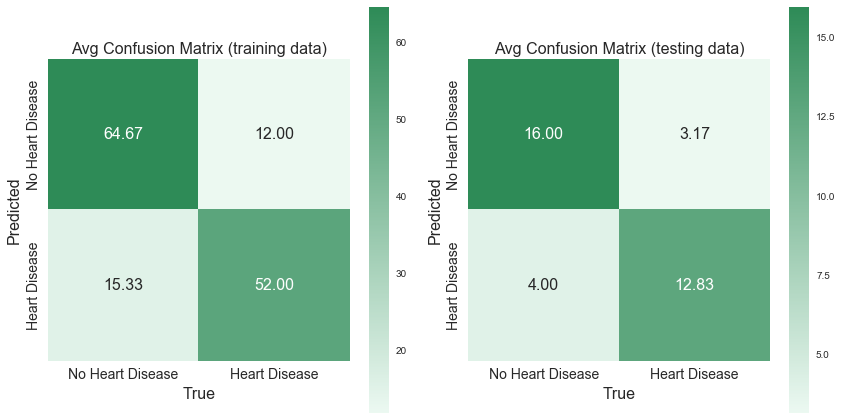

In [87]:
cross_validated_cm_generator(clf_=logreg_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Support Vector Classifiers <a id="SVC"></a>

Support Vector classifiers are another linear classifier (ie another classifier which uses a linear combination of feature weights), except SVCs are able to produce a much more sophisticated decision boundary. This time, I'll start off using a pipeline and normalizing features.

In [91]:
steps = [('scaler', StandardScaler()),
         ('svm', SVC())]
pipeline = Pipeline(steps)
parameters = [{'svm__kernel':['rbf', 'poly', 'sigmoid'],
               'svm__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
               'svm__gamma':[0.001, 0.005, 0.01, 0.05, 0.1]}]
svm_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
svm_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 135 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 2276 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed:   13.5s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svm__kernel': ['rbf', 'poly', 'sigmoid'], 'svm__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'svm__gamma': [0.001, 0.005, 0.01, 0.05, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [92]:
print("Best CV params", svm_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(svm_gs.best_score_))

Best CV params {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Average Accuracy of the best model: 0.7953703703703703


From the printout, we can see that the best model uses the 'rbf' kernel (Radial Basis Function) and hyperparamaters $C = 100$ and $\gamma \text{ (gamma)} = 0.01$ 

In [133]:
grid_clf = svm_gs
svm_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                    'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                    'kernel': grid_clf.cv_results_['param_svm__kernel'],
                    'C': grid_clf.cv_results_['param_svm__C'], 
                    'gamma': grid_clf.cv_results_['param_svm__gamma']} 

map_df = pd.DataFrame(svm_grid_dict)

#### Hyperparameter Performance

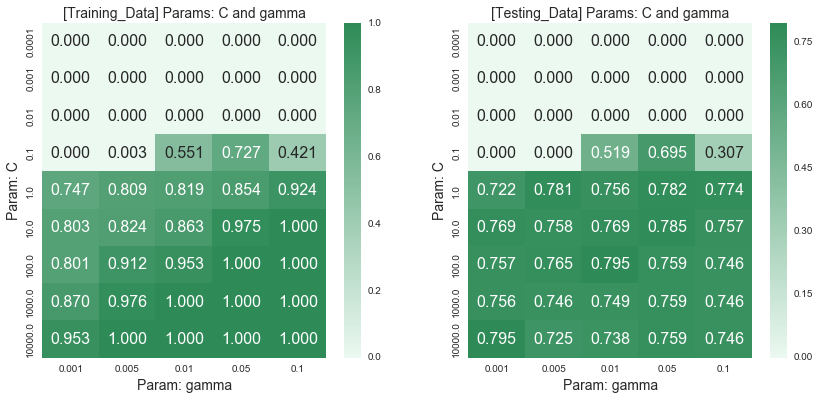

In [134]:
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'rbf'])

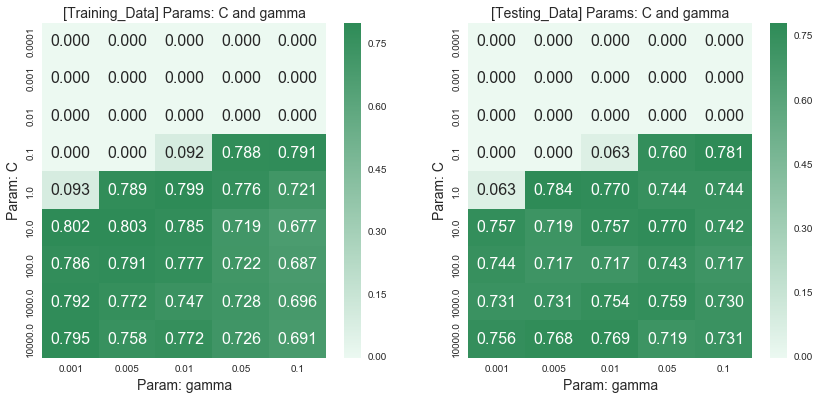

In [135]:
# Sigmoid SVC results
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'sigmoid'])

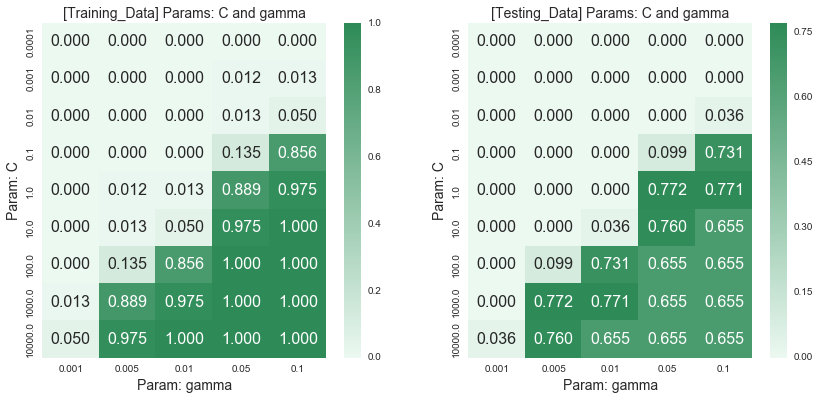

In [136]:
# Polynomial SVC results
train_test_param_map(x_var_='gamma', y_var_='C', map_df_=map_df[map_df['kernel'] == 'poly'])

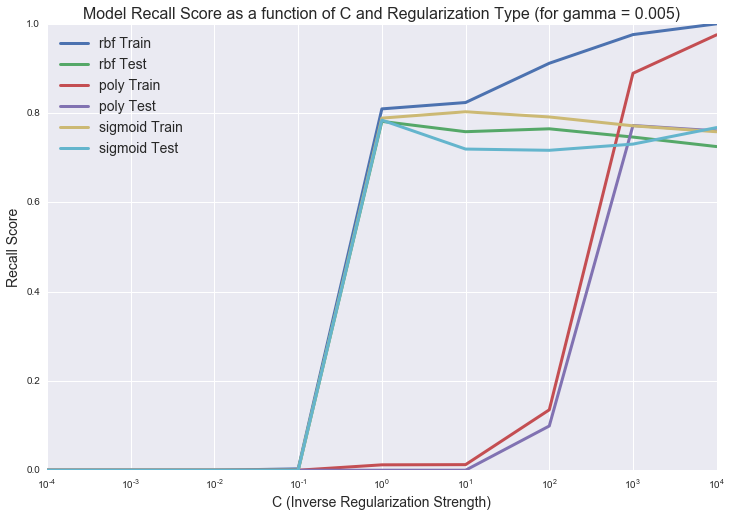

In [138]:
x_var = map_df[map_df['kernel'] == 'rbf']
x_var = x_var[x_var['gamma'] == 0.005]['C']
rbf = map_df[map_df['kernel'] == 'rbf']
rbf = rbf[rbf['gamma'] == 0.005]
poly = map_df[map_df['kernel'] == 'poly']
poly = poly[poly['gamma'] == 0.005]
sigmoid = map_df[map_df['kernel'] == 'sigmoid']
sigmoid = sigmoid[sigmoid['gamma'] == 0.005]

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, rbf['mean_train_score'], label='rbf Train', linewidth=3)
ax.semilogx(x_var, rbf['mean_test_score'], label='rbf Test', linewidth=3)
ax.semilogx(x_var, poly['mean_train_score'], label='poly Train', linewidth=3)
ax.semilogx(x_var, poly['mean_test_score'], label='poly Test', linewidth=3)
ax.semilogx(x_var, sigmoid['mean_train_score'], label='sigmoid Train', linewidth=3)
ax.semilogx(x_var, sigmoid['mean_test_score'], label='sigmoid Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Recall Score as a function of C and Regularization Type (for gamma = 0.005)', fontsize=16)
ax.set_xlabel('C (Inverse Regularization Strength)', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [98]:
print('Best accuracy: {:0.3f}%'.format(svm_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(svm_gs.best_params_))

Best accuracy: 79.537%
Best parameter(s): {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


The confusion matrices below used a **Support Vector Classifier** with parameters {$C = 100$, kernel $= \text{rbf}$, and $\gamma = 0.01$}, used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.97$ unhealthy people as being healthy, which is slightly worse than the best logistic regression classifier above, and this model labeled $4.17$ healthy people as unhealthy which is slightly worse than the best logistic regression model.

This is a not an improvement on our best model.

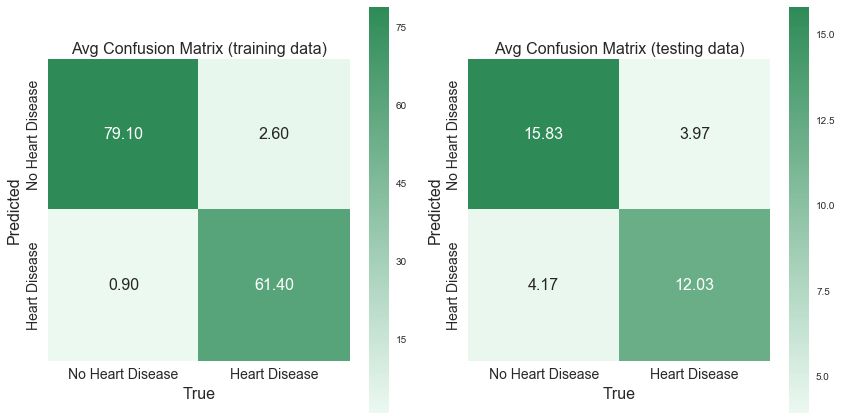

In [99]:
cross_validated_cm_generator(clf_=svm_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Decision Tree Classifier <a id="dtree"></a>

In [100]:
steps = [('dt', DecisionTreeClassifier())]
pipeline = Pipeline(steps)
parameters = [{'dt__criterion':['entropy', 'gini'],
               'dt__max_depth':[2,5,7,10], 
               'dt__min_samples_leaf':[1,2,3,4,5], 
               'dt__random_state':[nb_seed]}]
dt_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=9)
dt_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 40 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    6.6s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'dt__criterion': ['entropy', 'gini'], 'dt__max_depth': [2, 5, 7, 10], 'dt__min_samples_leaf': [1, 2, 3, 4, 5], 'dt__random_state': [1234]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=9)

In [101]:
print("Best CV params", dt_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(dt_gs.best_score_))

Best CV params {'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__random_state': 1234}
Average Accuracy of the best model: 0.7333333333333333


From the printout, we can see that the best model uses the 'gini' information criterion to determine when to split, a max depth of 5 nodes, and at least 1 sample for any leaf.

In [127]:
grid_clf = dt_gs
dt_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'criterion': grid_clf.cv_results_['param_dt__criterion'],
                'max_depth': grid_clf.cv_results_['param_dt__max_depth'], 
                'min_samples_leaf': grid_clf.cv_results_['param_dt__min_samples_leaf']} 

map_df = pd.DataFrame(dt_grid_dict)

#### Hyperparameter Performance

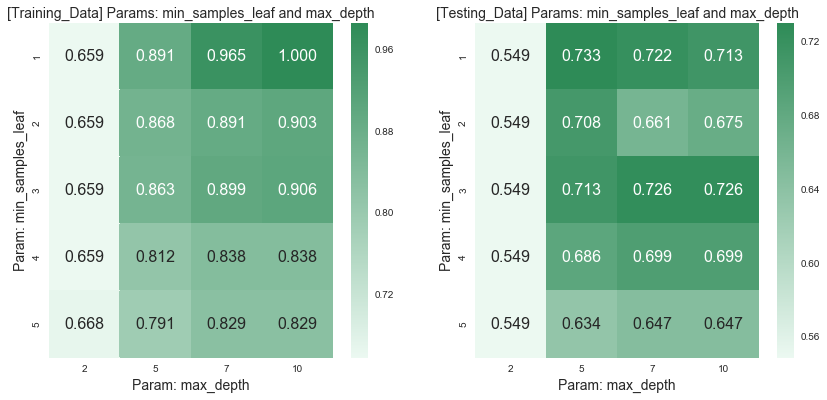

In [128]:
train_test_param_map(x_var_='max_depth', y_var_='min_samples_leaf', map_df_=map_df[map_df['criterion'] == 'gini'])

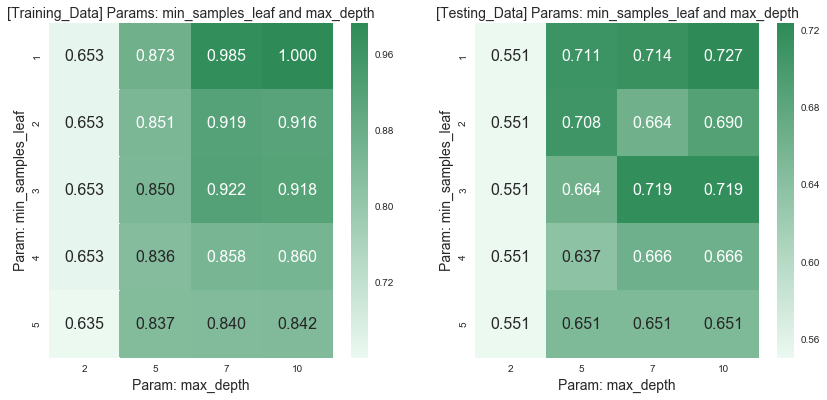

In [129]:
train_test_param_map(x_var_='max_depth', y_var_='min_samples_leaf', map_df_=map_df[map_df['criterion'] == 'entropy'])

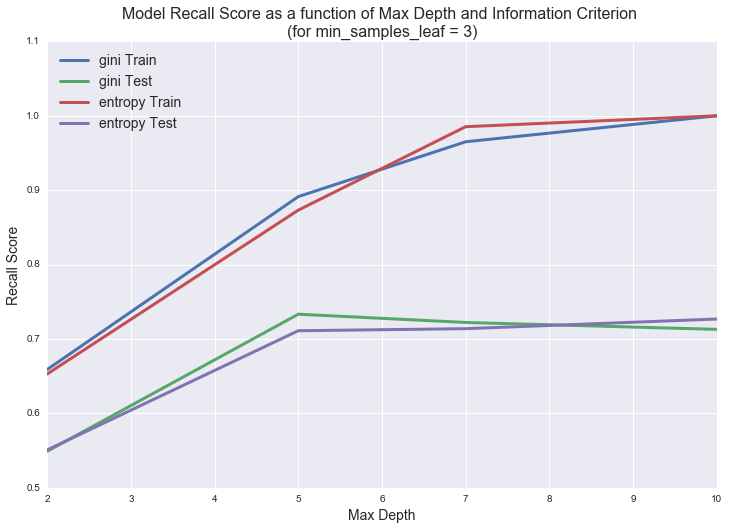

In [130]:
x_var = map_df[map_df['criterion'] == 'gini']
x_var = x_var[x_var['min_samples_leaf'] == 1]['max_depth']
gini = map_df[map_df['criterion'] == 'gini']
gini = gini[gini['min_samples_leaf'] == 1]
entropy = map_df[map_df['criterion'] == 'entropy']
entropy = entropy[entropy['min_samples_leaf'] == 1]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_var, gini['mean_train_score'], label='gini Train',linewidth=3)
ax.plot(x_var, gini['mean_test_score'], label='gini Test', linewidth=3)
ax.plot(x_var, entropy['mean_train_score'], label='entropy Train', linewidth=3)
ax.plot(x_var, entropy['mean_test_score'], label='entropy Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Recall Score as a function of Max Depth and Information Criterion \n(for min_samples_leaf = 3)', fontsize=16)
ax.set_xlabel('Max Depth', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [131]:
print('Best accuracy: {:0.3f}%'.format(dt_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(dt_gs.best_params_))

Best accuracy: 73.333%
Best parameter(s): {'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__min_samples_leaf': 1, 'dt__random_state': 1234}


The confusion matrices below used a single **Decision Tree Classifier** with parameters {max_depth = 5, information criterion = gini, and min_samples_leaf = 1}, used  unnormalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $5.10$ unhealthy people as being healthy, which is worse than all of the previous classifiers, and this model labeled $4.50$ healthy people as unhealthy which is also worse than all previous classifiers.

This model is not an improvement over our previous models, but as I explain below, this kind of model has a very convenient method for interpretation. 

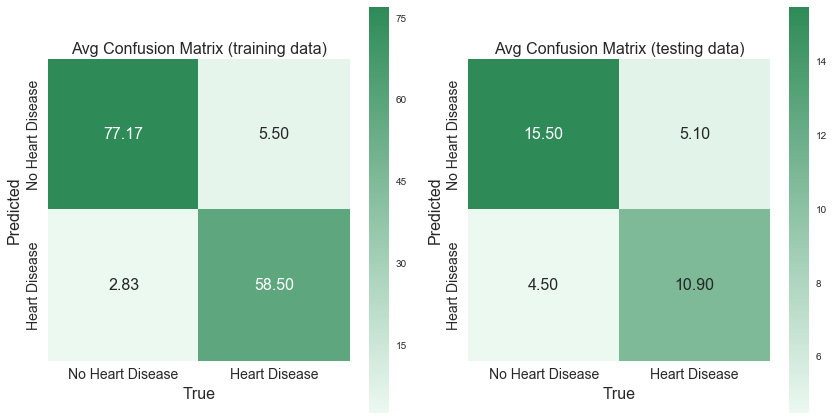

In [132]:
cross_validated_cm_generator(clf_=dt_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

In [109]:
data_train, data_test, class_train, class_test = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size=0.3,
                                                                  stratify=y_train,
                                                                  random_state=123)
dt_best = DecisionTreeClassifier(max_depth=7, min_samples_leaf=3, criterion='gini')
dt_best.fit(data_train, class_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [110]:
export_graphviz(dt_best,out_file='single_dtree.dot', feature_names=data_train.columns,
                rounded=True, filled=True, rotate=True,
                class_names=['No Heart Disease', 'Heart Disease'])

**Decision Trees** are easily interpretable. To classify a new observation, you simply evaluate the question at each node (eg: is the observation's value for thal_reversible_defect less than 0.5? (note: thal_reversible_defect is a binary category, so essentially this is asking did the observation have thal_reversible_defect?)), and if true, you follow the upper branch and if false, you follow the lower branch. Continue this process until you arrive at a node with no branches, and whatever class is listed at that node is the class predicted by the model. 

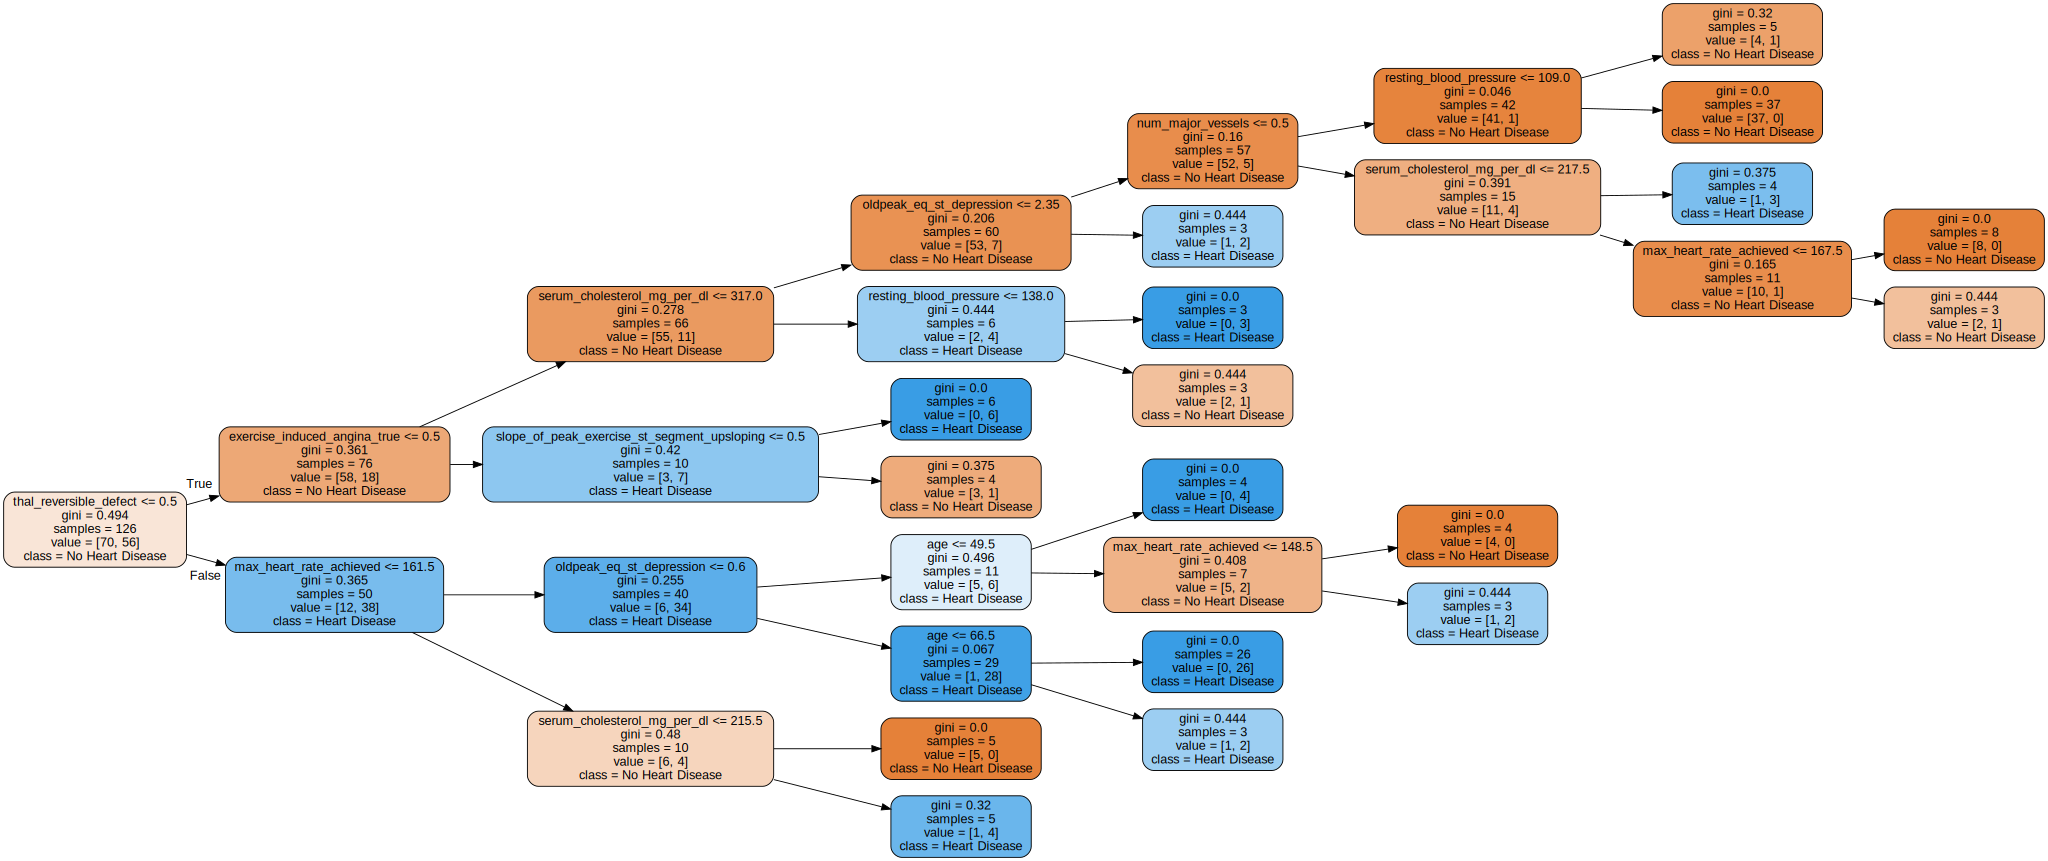

In [111]:
with open('single_dtree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## K Nearest Neighbors <a id="knn"></a>

**K Nearest Neighbors** (or **KNN**) is an algorithm that determines an observation's class by polling the $k$-nearest observations what their classes are and choosing the most common class. The nearness of different observations depends on the distance function used. The most commonly used distance function is the euclidean function, which extends the Pythogorean equation up from $2$ dimensions to $n$ dimensions (for datasets with $n$ features).

In [112]:
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = [{'knn__n_neighbors':[1,3,5,7,9,11,13,15],
               'knn__weights':['uniform', 'distance'], 
               'knn__metric':['manhattan', 'chebyshev', 'euclidean']}]
knn_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=9)
knn_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 48 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 713 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 1189 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    8.3s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'knn__weights': ['uniform', 'distance'], 'knn__metric': ['manhattan', 'chebyshev', 'euclidean']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=9)

In [113]:
print("Best CV params", knn_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(knn_gs.best_score_))

Best CV params {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
Average Accuracy of the best model: 0.8222222222222222


From the printout, we can see that the best model uses the manhattan distance metric, a uniform weighting of distance (ie closer neighbors don't have a more significant vote), and polls the 11 nearest neighbors.

In [115]:
grid_clf = knn_gs
knn_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'n_neighbors': grid_clf.cv_results_['param_knn__n_neighbors'],
                'weights': grid_clf.cv_results_['param_knn__weights'], 
                'metric': grid_clf.cv_results_['param_knn__metric']} 

map_df = pd.DataFrame(knn_grid_dict)

#### Hyperparameter Performance

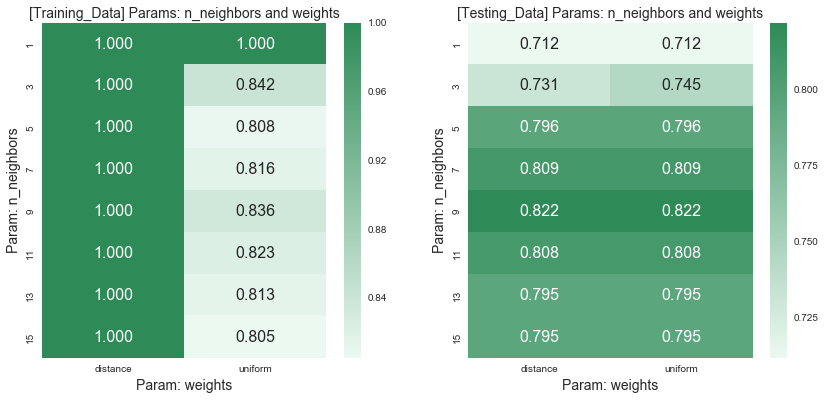

In [116]:
# Euclidean distance
train_test_param_map(x_var_='weights', y_var_='n_neighbors', map_df_=map_df[map_df['metric'] == 'euclidean'])

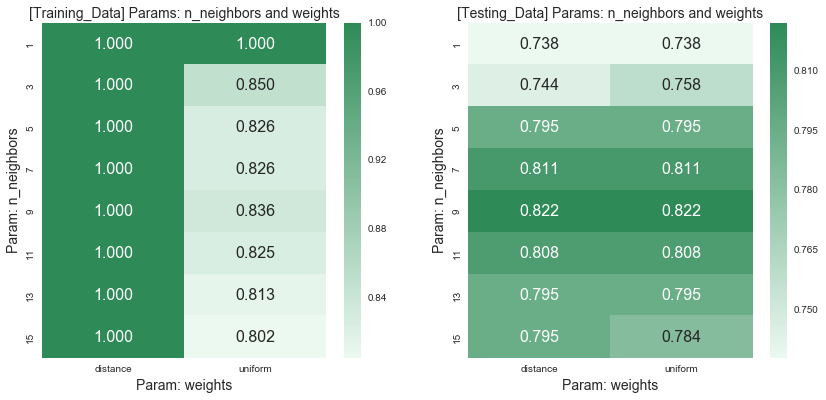

In [117]:
# Manhattan Distance
train_test_param_map(x_var_='weights', y_var_='n_neighbors', map_df_=map_df[map_df['metric'] == 'manhattan'])

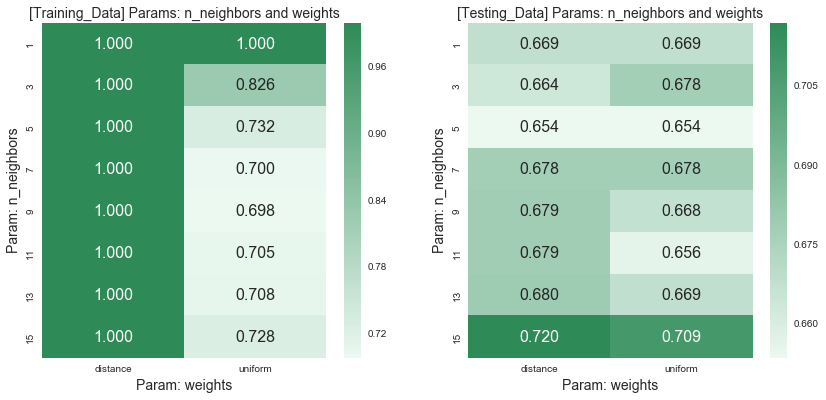

In [118]:
# Chebyshev Metric
train_test_param_map(x_var_='weights', y_var_='n_neighbors', map_df_=map_df[map_df['metric'] == 'chebyshev'])

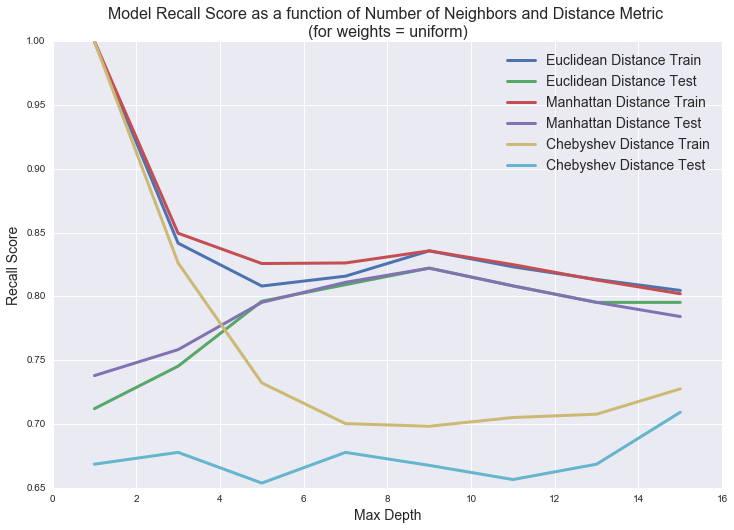

In [123]:
x_var = map_df[map_df['metric'] == 'euclidean']
x_var = x_var[x_var['weights'] == 'uniform']['n_neighbors']
euclidean = map_df[map_df['metric'] == 'euclidean']
euclidean = euclidean[euclidean['weights'] == 'uniform']
manhattan = map_df[map_df['metric'] == 'manhattan']
manhattan = manhattan[manhattan['weights'] == 'uniform']
chebyshev = map_df[map_df['metric'] == 'chebyshev']
chebyshev = chebyshev[chebyshev['weights'] == 'uniform']

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_var, euclidean['mean_train_score'], label='Euclidean Distance Train', linewidth=3)
ax.plot(x_var, euclidean['mean_test_score'], label='Euclidean Distance Test', linewidth=3)
ax.plot(x_var, manhattan['mean_train_score'], label='Manhattan Distance Train', linewidth=3)
ax.plot(x_var, manhattan['mean_test_score'], label='Manhattan Distance Test', linewidth=3)
ax.plot(x_var, chebyshev['mean_train_score'], label='Chebyshev Distance Train', linewidth=3)
ax.plot(x_var, chebyshev['mean_test_score'], label='Chebyshev Distance Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Model Recall Score as a function of Number of Neighbors and Distance Metric \n(for weights = uniform)', fontsize=16)
ax.set_xlabel('Max Depth', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [124]:
print('Best accuracy: {:0.3f}%'.format(knn_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(knn_gs.best_params_))

Best accuracy: 82.222%
Best parameter(s): {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'}


The confusion matrices below used a **K-Nearest Neighbors Classifier** with parameters {n_neighbors = 11, weights = uniform, and distance metric = manhattan}, used  normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.23$ unhealthy people as being healthy, which is better than all of the previous classifiers, and this model labeled $3.37$ healthy people as unhealthy which is better than all other classifiers that used the recall scoring measure.

This is our best model so far.

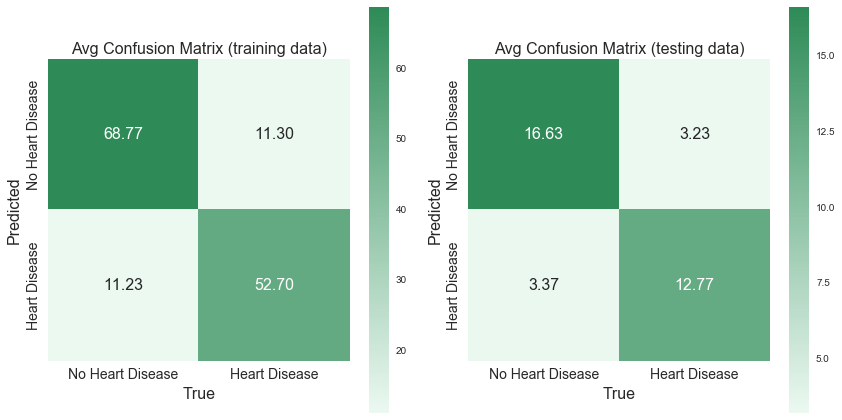

In [125]:
cross_validated_cm_generator(clf_=knn_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Naive Bayes <a id="nbayes"></a>

**Bayes theorem** states that for independent events $A$ and $B$, the probability of $A$ given knowledge of $B$ is the probability of $B$ given $A$ times the probability of $A$ divided by the probability of $B$. Or stated more formally,

$$P(A\, | \,B) = \frac{P(B \, | \, A)P(A)}{P(B)}$$

**Naive Bayes** classifiers make the 'naive' assumption that all features are independent and uses the values of other features to determine the class probability. While this assumption is rarely true in practice, naive Bayes classifiers are extremely quick and surprisingly accurate.

In [140]:
steps = [('scaler', StandardScaler()),
         ('bnb', BernoulliNB())]
pipeline = Pipeline(steps)
parameters = [{'bnb__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]}]
bnb_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
bnb_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 9 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    5.8s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bnb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'bnb__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [142]:
print("Best CV params", bnb_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(bnb_gs.best_score_))

Best CV params {'bnb__alpha': 0.0001}
Average Accuracy of the best model: 0.7962962962962962


From the printout, we can see that the best model uses an alpha (smoothing parameter) value of 0.0001.

In [143]:
grid_clf = bnb_gs
bnb_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'alpha': grid_clf.cv_results_['param_bnb__alpha']} 

map_df = pd.DataFrame(bnb_grid_dict)

#### Hyperparameter Performance

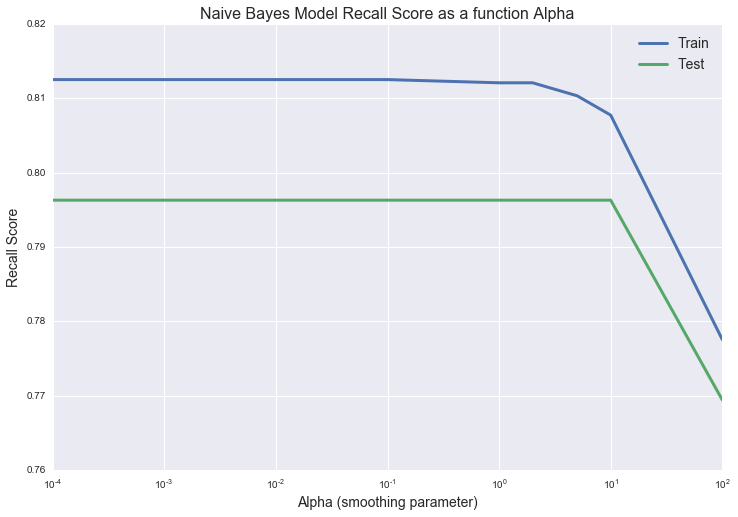

In [144]:
x_var = map_df['alpha']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df['mean_train_score'], label='Train', linewidth=3)
ax.semilogx(x_var, map_df['mean_test_score'], label='Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Naive Bayes Model Recall Score as a function Alpha', fontsize=16)
ax.set_xlabel('Alpha (smoothing parameter)', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [145]:
print('Best accuracy: {:0.3f}%'.format(bnb_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(bnb_gs.best_params_))

Best accuracy: 79.630%
Best parameter(s): {'bnb__alpha': 0.0001}


The confusion matrices below used a **Naive Bayes Classifier** with parameter {alpha = 0.0001} (although it looks like the accuracy was the same for all values of alpha up to 1.0), used normalized data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.17$ unhealthy people as being healthy, which is as good as the best classifier yet (logistic regression), and this model labeled $3.93$ healthy people as unhealthy, which is better than our best previous classifier.

This model is our best model so far, and it's lightning fast. If runtime is an issue, Naive Bayes is a strong choice.

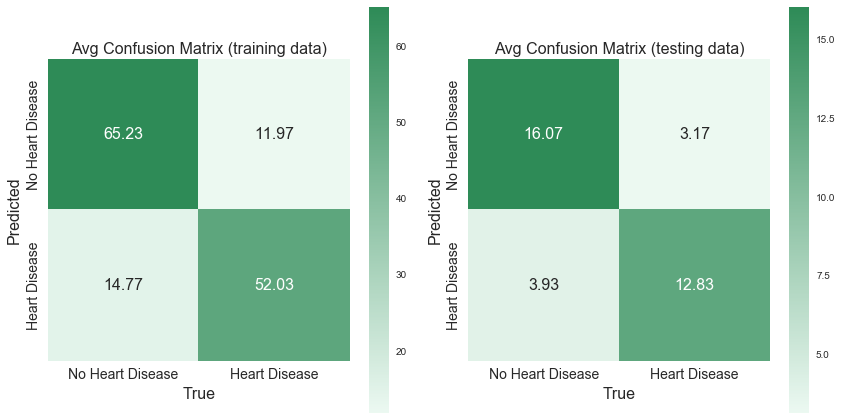

In [146]:
cross_validated_cm_generator(clf_=bnb_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Naive Bayes without Scaling <a id="nbayes_unscaled"></a>

Last time, I used normalized (scaled) data to train the naive Bayes classifier. Here, I'll see the effect of using **unnormalized** data. 

In [149]:
steps = [('bnb', BernoulliNB())]
pipeline = Pipeline(steps)
parameters = [{'bnb__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]}]
bnb_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
bnb_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 9 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    5.5s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('bnb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'bnb__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [150]:
print("Best CV params", bnb_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(bnb_gs.best_score_))

Best CV params {'bnb__alpha': 10}
Average Accuracy of the best model: 0.7962962962962962


From the printout, we can see that the best model uses an alpha (smoothing parameter) value of 10.

In [152]:
grid_clf = bnb_gs
bnb_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'alpha': grid_clf.cv_results_['param_bnb__alpha']} 

map_df = pd.DataFrame(bnb_grid_dict)

#### Hyperparameter Performance

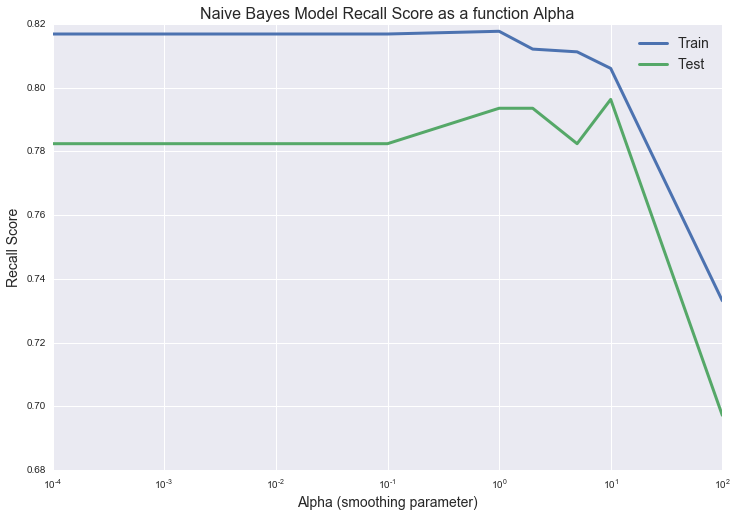

In [159]:
x_var = map_df['alpha']

fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(x_var, map_df['mean_train_score'], label='Train', linewidth=3)
ax.semilogx(x_var, map_df['mean_test_score'], label='Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('Naive Bayes Model Recall Score as a function Alpha', fontsize=16)
ax.set_xlabel('Alpha (smoothing parameter)', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [156]:
print('Best accuracy: {:0.3f}%'.format(bnb_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(bnb_gs.best_params_))

Best accuracy: 79.630%
Best parameter(s): {'bnb__alpha': 10}


The confusion matrices below used a **Naive Bayes Classifier** with parameter {alpha = 10} (although it looks like the accuracy was the same for all values of alpha up to 0.1), used **unnormalized** data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.30$ unhealthy people as being healthy, and this model labeled $3.60$ healthy people as unhealthy.

Data normalization was the only difference between this and the previous model, and from this result, normalizing produced better accuracy. 

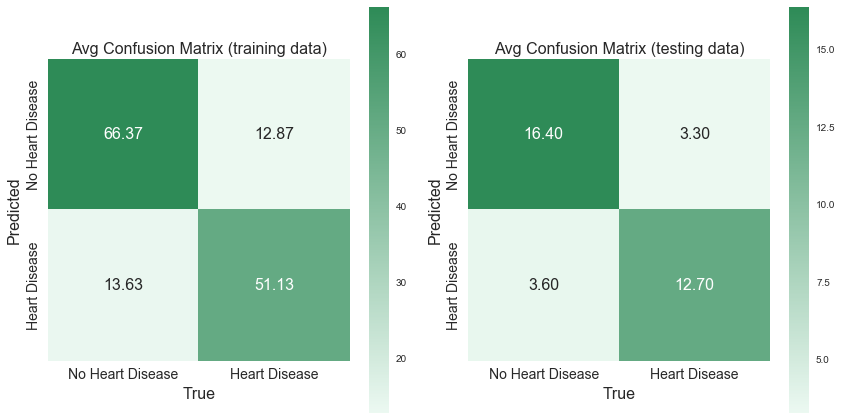

In [157]:
cross_validated_cm_generator(clf_=bnb_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Random Forest Classifier <a id="random_forest"></a>

**Random Forest** classifiers are an extension of **Decision Tree** classifiers which produce more reliable predictions. Random Forests are an ensemble of similar decision trees, and the predictions of a random forest classifier are the most common prediction of the individual Decision Trees in that forest. As many trees are used to make the forest, we can't produce an easily interpretable tree as we did above, but we can look at the significance of each of the individual features.

In [158]:
steps = [('rf', RandomForestClassifier())]
pipeline = Pipeline(steps)
parameters = [{'rf__n_estimators':[200,300,400], 
               'rf__criterion': ['gini', 'entropy'], 
               'rf__max_features':[6,12,18], 
               'rf__max_depth': [2,5,8,11], 
               'rf__min_samples_leaf': [1,3,5]}]
rf_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
rf_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 216 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4125 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4786 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 5497 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:  9.4mi

GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'rf__n_estimators': [200, 300, 400], 'rf__criterion': ['gini', 'entropy'], 'rf__max_features': [6, 12, 18], 'rf__max_depth': [2, 5, 8, 11], 'rf__min_samples_leaf': [1, 3, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [160]:
print("Best CV params", rf_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(rf_gs.best_score_))

Best CV params {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 6, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 200}
Average Accuracy of the best model: 0.7740740740740739


From the printout, we can see that the best model uses the following hyperparameter values:
* Information Criterion: Gini
* Max Depth: 11
* Max Features: 6 
* Min Samples Per Leaf: 3
* Number of Trees: 200

In [161]:
grid_clf = rf_gs
rf_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'criterion': grid_clf.cv_results_['param_rf__criterion'], 
                'n_estimators': grid_clf.cv_results_['param_rf__n_estimators'],
                'max_depth': grid_clf.cv_results_['param_rf__max_depth'],
                'max_features': grid_clf.cv_results_['param_rf__max_features'],
                'min_samples_leaf': grid_clf.cv_results_['param_rf__min_samples_leaf']} 

map_df = pd.DataFrame(rf_grid_dict)

#### Hyperparameter Performance

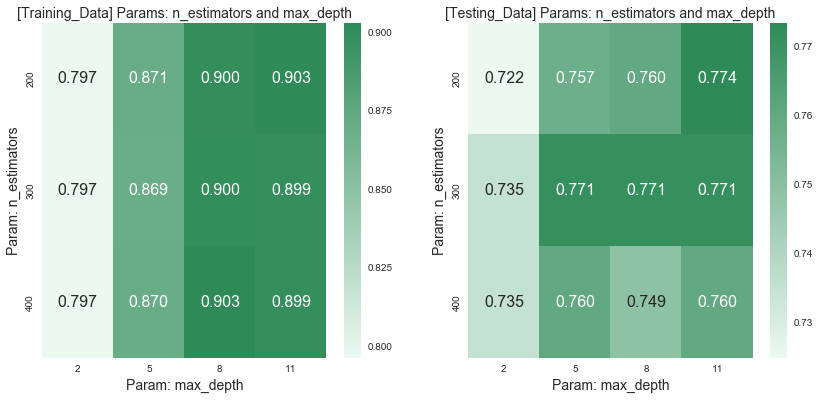

In [162]:
# Looking at variation over max_depth and n_estimators 
# using the best values of max_features, min_samples_leaf, and criterion
tmp = map_df[(map_df['criterion'] == 'gini') & \
             (map_df['min_samples_leaf'] == 3) & \
             (map_df['max_features'] == 6)]

train_test_param_map(x_var_='max_depth', y_var_='n_estimators', map_df_=tmp)

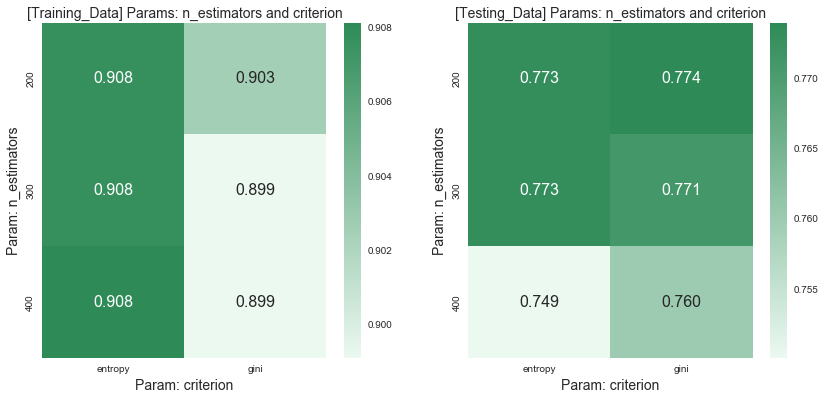

In [164]:
# Looking at variation over criterion and n_estimators 
# using the best values of max_features, min_samples_leaf, and max_depth
tmp = map_df[(map_df['max_depth'] == 11) & \
             (map_df['min_samples_leaf'] == 3) & \
             (map_df['max_features'] == 6)]

train_test_param_map(x_var_='criterion', y_var_='n_estimators', map_df_=tmp)

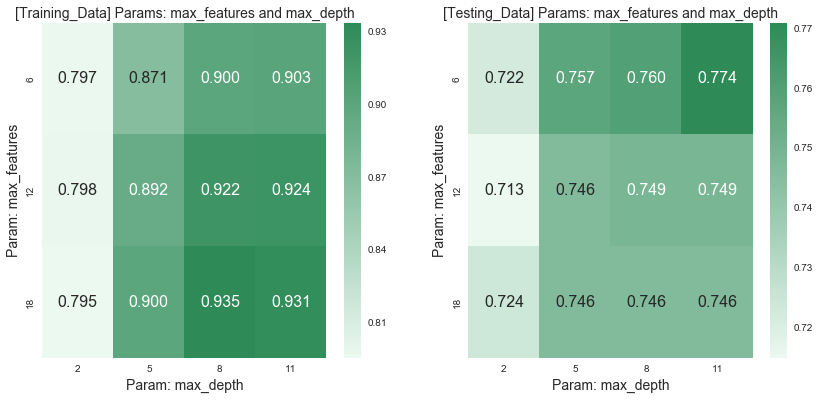

In [165]:
# Looking at variation over max_depth and max_features 
# using the best values of criterion, min_samples_leaf, and n_estimators
tmp = map_df[(map_df['criterion'] == 'gini') & \
             (map_df['min_samples_leaf'] == 3) & \
             (map_df['n_estimators'] == 200)]

train_test_param_map(x_var_='max_depth', y_var_='max_features', map_df_=tmp)

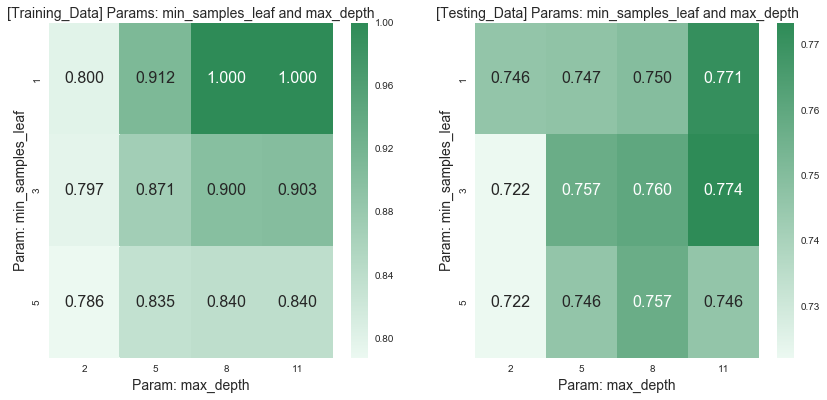

In [166]:
# Looking at variation over max_depth and min_samples_leaf 
# using the best values of criterion, max_features, and n_estimators
tmp = map_df[(map_df['criterion'] == 'gini') & \
             (map_df['max_features'] == 6) & \
             (map_df['n_estimators'] == 200)]

train_test_param_map(x_var_='max_depth', y_var_='min_samples_leaf', map_df_=tmp)

In [167]:
print('Best accuracy: {:0.3f}%'.format(rf_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(rf_gs.best_params_))

Best accuracy: 77.407%
Best parameter(s): {'rf__criterion': 'gini', 'rf__max_depth': 11, 'rf__max_features': 6, 'rf__min_samples_leaf': 3, 'rf__n_estimators': 200}


The confusion matrices below are for the **Random Forest Classifier** with above parameters, was trained with **unnormalized** data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.67$ unhealthy people as being healthy, and this model labeled $3.47$ healthy.

While this classifier is average among the other classifiers we've seen so far, it did perform significantly better than singular Decision Trees, which demonstrates the power of using ensembles of classifiers.

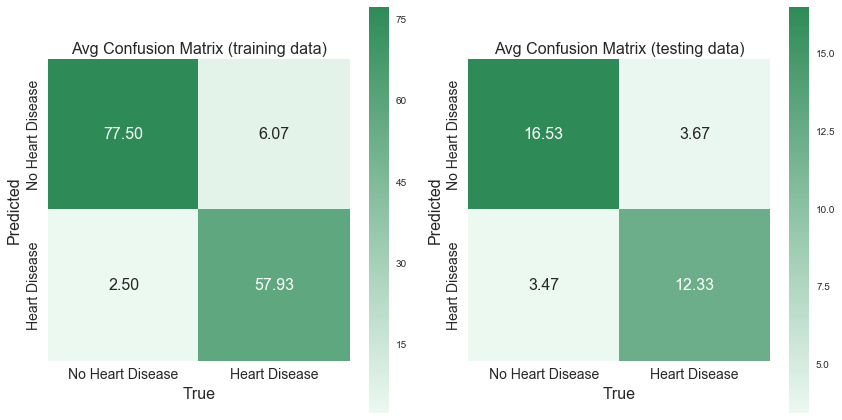

In [168]:
cross_validated_cm_generator(clf_=rf_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

In [169]:
rf_best = RandomForestClassifier(criterion='gini', max_depth=11, max_features=6, min_samples_leaf=3, n_estimators=200)
rf_best.fit(X_train, y_train)

C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Random Forest Feature Importances  <a id="random_forest_feats"></a>

While the best Random Forest Classifier had slightly sub-par overall performance, it does allow us to see how significant features were in the predictions it generated. As the model was rather accurate (>80%), we can be confident that these features importances will be reasonably representative of the true feature importances. 

In making dummy variables, I had to drop one column per feature as a full set of columns would always have a redundant column (details: if 1 column had 3 unique values, it would require 1 new column for each unique variable. If, for any given observation, 2 of those columns both contained zeros, then we would know the last column contained a 1, or if either of the first 2 columns contained a 1, we would know the last column contained a 0. Essentially, one column would always be redundant and for linear algebra reasons, could distort results). Consequently, having all but one of the columns from a feature could indicate that the missing feature is the significant one. I suspect that may be the case with the thalium stress test features, as all two remaining thalium stress test features are important. 

We also see that oldpeak_eq_st_depression (the ST depression in an EKG reading observed after exercise) is significant, as well as the number of major blood vessels colored by fluoroscopy (an indicator of ischemic insufficiency), max heart rate, exercise induced angina, cholesterol level, and age are also fairly significant, with importance dwindling after this point. 

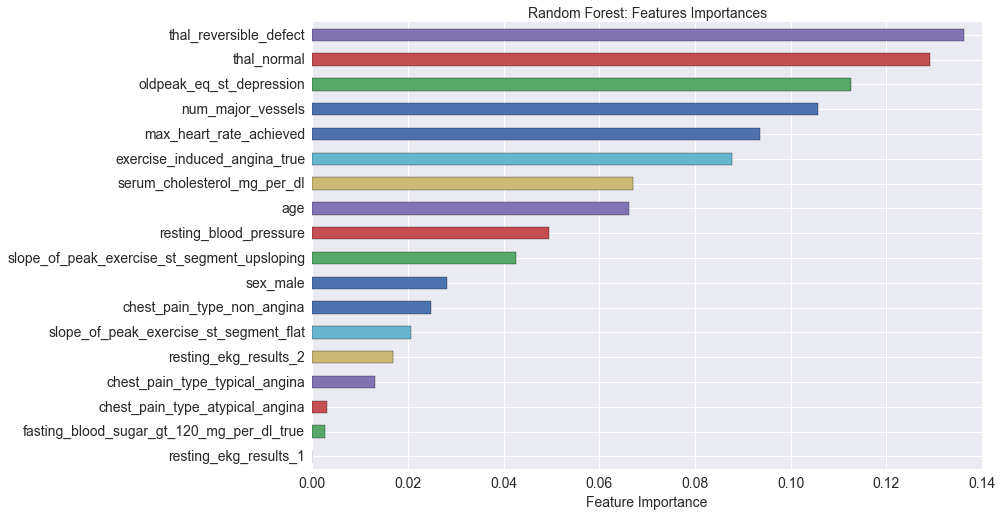

In [170]:
importances = pd.Series(data=rf_best.feature_importances_, index= X_train.columns)
importances_sorted = importances.sort_values()
ax = importances_sorted.plot(kind='barh', figsize=(12,8), fontsize=14)
ax.set_title('Random Forest: Features Importances', fontsize=14)
ax.set_xlabel('Feature Importance', fontsize=14)
plt.show()

### AdaBoost Classifier <a id="ada"></a>

Up to this point, all of the ensemble classifiers we've trained have generated a lot of models in parallel and polled the individual models to generate predictions. The **AdaBoost** classifier introduce the concept of **learner strength**. The previous classifiers are **strong learners** that quickly learn the bias of the data. The AdaBoost classifier, in contrast, generates an ensemble of **weak learners** that only perform slightly better than random (50/50), but the output from an AdaBoost classifier is then passed as input into the AdaBoost classifier, and this process repeats and ever iteration, the AdaBoost classifier adjusts the weighting for the ensemble elements that misclassified observations. After $n$ iterations, the classifier is well tuned and can perform comparably to other classifiers. 

Because AdaBoost classifiers require sequential improvement, they can't be parallelized in the way that strong learner classifiers can be parallelized. 

In [171]:
dt = DecisionTreeClassifier()
bnb = BernoulliNB()
steps = [('ada', AdaBoostClassifier())]
pipeline = Pipeline(steps)
parameters = [{'ada__base_estimator':[dt, bnb], 
               'ada__n_estimators': [100,200,300], 
               'ada__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
               'ada__algorithm': ['SAMME.R']}]
ada_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
ada_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   45.0s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'ada__base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...00, 200, 300], 'ada__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'ada__algorithm': ['SAMME.R']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [173]:
print("Best CV params", ada_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(ada_gs.best_score_))

Best CV params {'ada__algorithm': 'SAMME.R', 'ada__base_estimator': BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 'ada__learning_rate': 0.1, 'ada__n_estimators': 300}
Average Accuracy of the best model: 0.7972222222222223


From the printout, we can see that the best model uses the following hyperparameter values:
* Algorithm: SAMME.R
* Base Estimator: Naive Bayes (Bernoulli Implementation)
* Learning Rate: 0.1
* Number of Models: 30

In [174]:
grid_clf = ada_gs
ada_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'estimator': grid_clf.cv_results_['param_ada__base_estimator'], 
                'n_estimators': grid_clf.cv_results_['param_ada__n_estimators'],
                'learning_rate': grid_clf.cv_results_['param_ada__learning_rate']} 

map_df = pd.DataFrame(ada_grid_dict)

#### Hyperparameter Performance

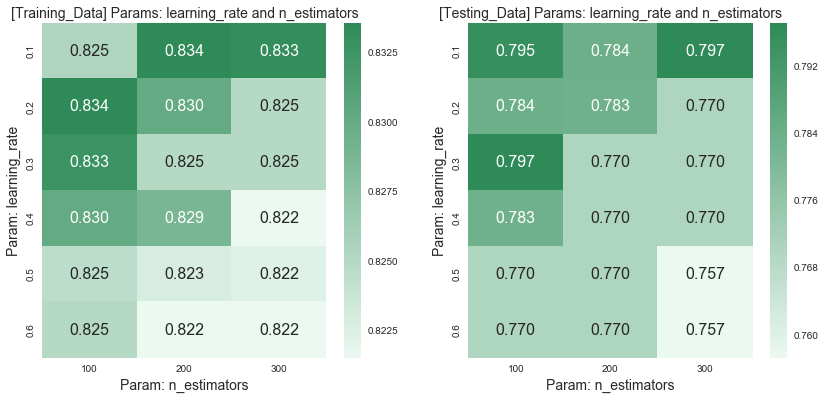

In [175]:
# Looking at variation over learning_rate and n_estimators with a Naive Bayes base_estimator
tmp = map_df[(map_df['estimator'] == bnb)]

train_test_param_map(x_var_='n_estimators', y_var_='learning_rate', map_df_=tmp)

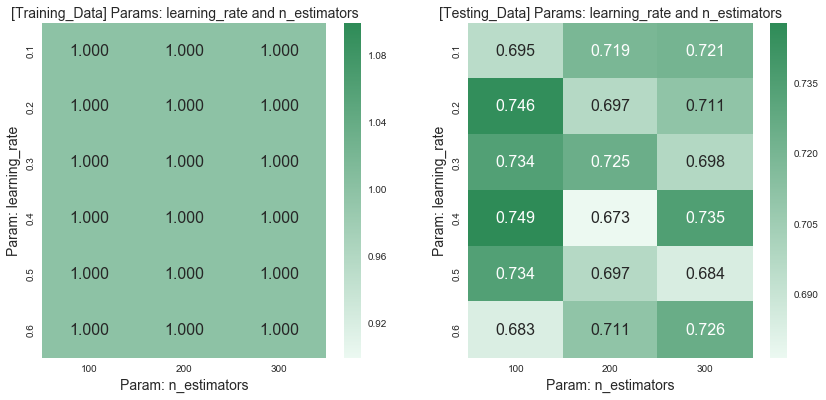

In [176]:
# Looking at variation over learning_rate and n_estimators with a Decision Tree base_estimator
tmp = map_df[(map_df['estimator'] == dt)]

train_test_param_map(x_var_='n_estimators', y_var_='learning_rate', map_df_=tmp)

When Decision Trees were used as the base estimator, we see that AdaBoost was able to tune the weights on the training set to adjust weights to completely fit the training data, but it did not generalize very well to the testing data. This is an extreme example of overfitting. 

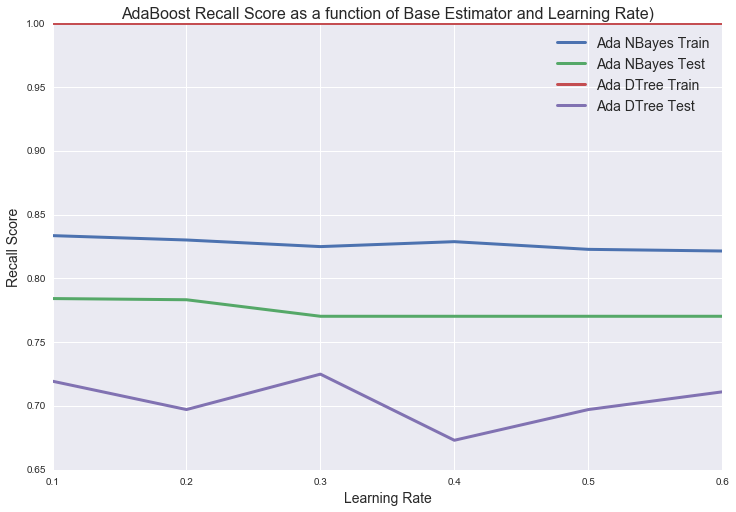

In [177]:
x_var = map_df[(map_df['estimator'] == bnb) & (map_df['n_estimators'] == 200)]['learning_rate']
ada_bnb = map_df[(map_df['estimator'] == bnb) & (map_df['n_estimators'] == 200)]
dt_bnb = map_df[(map_df['estimator'] == dt) & (map_df['n_estimators'] == 200)]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_var, ada_bnb['mean_train_score'], label='Ada NBayes Train', linewidth=3)
ax.plot(x_var, ada_bnb['mean_test_score'], label='Ada NBayes Test', linewidth=3)
ax.plot(x_var, dt_bnb['mean_train_score'], label='Ada DTree Train', linewidth=3)
ax.plot(x_var, dt_bnb['mean_test_score'], label='Ada DTree Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('AdaBoost Recall Score as a function of Base Estimator and Learning Rate)', fontsize=16)
ax.set_xlabel('Learning Rate', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [178]:
print('Best accuracy: {:0.3f}%'.format(ada_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(ada_gs.best_params_))

Best accuracy: 79.722%
Best parameter(s): {'ada__algorithm': 'SAMME.R', 'ada__base_estimator': BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True), 'ada__learning_rate': 0.1, 'ada__n_estimators': 300}


The confusion matrices below are for the **AdaBoost Classifier** with above parameters, was trained with **unnormalized** data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.03$ unhealthy people as being healthy, and this model labeled $2.97$ healthy as unhealthy.

This is our best model up to this point.

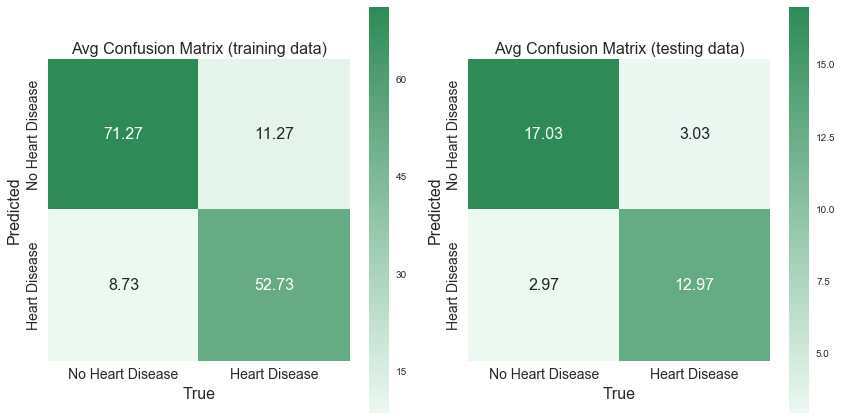

In [179]:
cross_validated_cm_generator(clf_=ada_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## AdaBoost with Scaled Data <a id="ada_scaled"></a>

The previous run was performed with base classifiers that do not do well with unscaled data. This time, I'll used the classifiers that reqire data to be scaled

In [180]:
svm = SVC()
logreg = LogisticRegression()
steps = [('scaler', StandardScaler()),
         ('ada', AdaBoostClassifier())]
pipeline = Pipeline(steps)
parameters = [{'ada__base_estimator':[svm, logreg], 
               'ada__n_estimators': [100,200,300], 
               'ada__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
               'ada__algorithm': ['SAMME']}]
ada_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
ada_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 36 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.5min finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ada', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'ada__base_estimator': [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), LogisticRegression(C=1.0, class_weigh...[100, 200, 300], 'ada__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'ada__algorithm': ['SAMME']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [181]:
print("Best CV params", ada_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(ada_gs.best_score_))

Best CV params {'ada__algorithm': 'SAMME', 'ada__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'ada__learning_rate': 0.1, 'ada__n_estimators': 100}
Average Accuracy of the best model: 0.812037037037037


From the printout, we can see that the best model uses the following hyperparameter values:
* Algorithm: SAMME
* Base Estimator: Logistic Regression
* Learning Rate: 0.1
* Number of Models: 100

In [182]:
grid_clf = ada_gs
ada_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                'estimator': grid_clf.cv_results_['param_ada__base_estimator'], 
                'n_estimators': grid_clf.cv_results_['param_ada__n_estimators'],
                'learning_rate': grid_clf.cv_results_['param_ada__learning_rate']} 

map_df = pd.DataFrame(ada_grid_dict)

#### Hyperparameter Performance

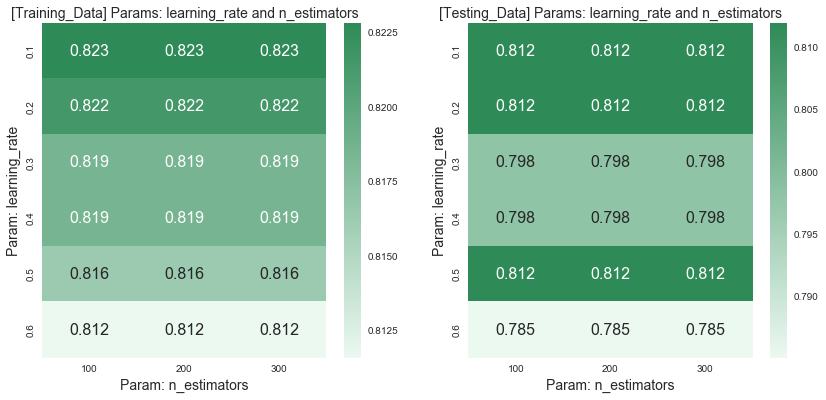

In [183]:
# Looking at variation over learning_rate and n_estimators with a LogisticRegression base_estimator
tmp = map_df[(map_df['estimator'] == logreg)]

train_test_param_map(x_var_='n_estimators', y_var_='learning_rate', map_df_=tmp)

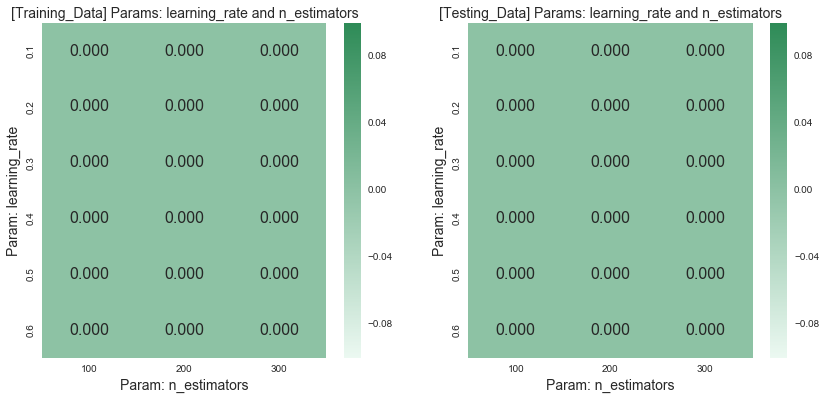

In [184]:
# Looking at variation over learning_rate and n_estimators with a Decision Tree base_estimator
tmp = map_df[(map_df['estimator'] == svm)]

train_test_param_map(x_var_='n_estimators', y_var_='learning_rate', map_df_=tmp)

Clearly something was misconfigured for the SVM classifier as that's garbage output.

In [185]:
map_df[(map_df['estimator'] == logreg) & (map_df['n_estimators'] == 200)]['learning_rate']

19    0.1
22    0.2
25    0.3
28    0.4
31    0.5
34    0.6
Name: learning_rate, dtype: object

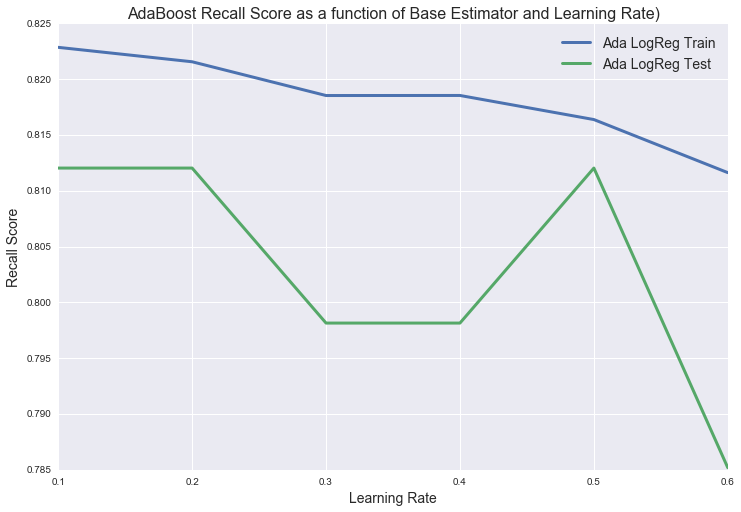

In [186]:
x_var = map_df[(map_df['estimator'] == logreg) & (map_df['n_estimators'] == 200)]['learning_rate']
ada_logreg = map_df[(map_df['estimator'] == logreg) & (map_df['n_estimators'] == 200)]
ada_svm = map_df[(map_df['estimator'] == svm) & (map_df['n_estimators'] == 200)]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_var, ada_logreg['mean_train_score'], label='Ada LogReg Train', linewidth=3)
ax.plot(x_var, ada_logreg['mean_test_score'], label='Ada LogReg Test', linewidth=3)
ax.legend(fontsize=14, loc='best')
ax.set_title('AdaBoost Recall Score as a function of Base Estimator and Learning Rate)', fontsize=16)
ax.set_xlabel('Learning Rate', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
plt.show()

In [187]:
print('Best accuracy: {:0.3f}%'.format(ada_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(ada_gs.best_params_))

Best accuracy: 81.204%
Best parameter(s): {'ada__algorithm': 'SAMME', 'ada__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'ada__learning_rate': 0.1, 'ada__n_estimators': 100}


The confusion matrices below are for the **AdaBoost Classifier** with above parameters, was trained with **normalized** data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.13$ unhealthy people as being healthy, and this model labeled $3.17$ healthy.

This performed pretty well. Not best, but in the upper fifth.

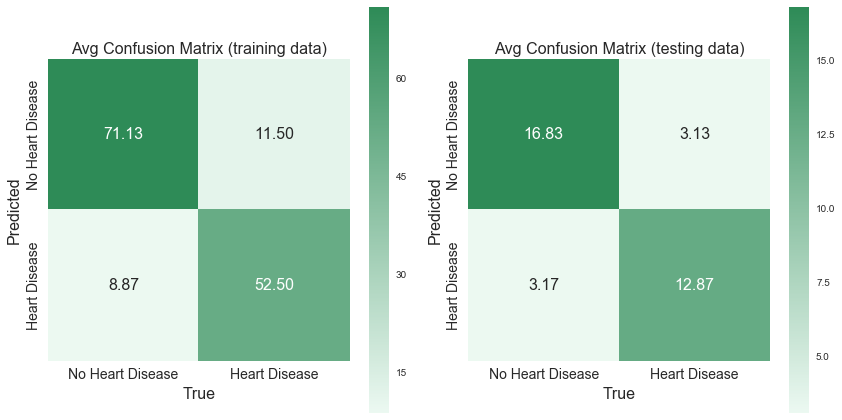

In [188]:
cross_validated_cm_generator(clf_=ada_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_ = y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Stochastic Gradient Boosting <a id="sgb"></a>

**Gradient Boosting** is similar to AdaBoost in that it uses an ensemble of weak learners that improve through iterative adjustment. At each iteration in the process, the constituent estimators adjust feature weights to minimize some differentiable cost/loss function, and they determine how to adjust these feature weights by calculating the gradient of the training data and then trying to fit to the negative gradient. 

It's a fairly sophisticated mathematical process and it's best to understand it in 3 dimensions first before jumping up to higher dimensions (each feature gets its own dimension). Imagine you're standing on the side of a hill and you're facing uphill. Behind you, the ground slopes down, in front of you, the ground slopes up, and to your left and right, the ground stays at the same height. Let's say the loss function is your gravitational potential energy (which is basically how high up you are). Some equation describes the shape of the hill you're standing on (for the hill below, it would be $z = 20 - (x^2 + y^2)$), and some function describes your gravitational potential energy ($F(x,y,z) = mgz = mg(20 - (x^2 + y^2))$). The gradient of $F(x,y,z) = \nabla F(x,y,z) = \big( \frac{\partial x}{\partial F}, \frac{\partial y}{\partial F}, \frac{\partial z}{\partial F} \big)$ is vector showing the direction that minimizes $F$, and the negative of the gradient is the vector showing the direction that minimizes $F$. For this hill, the negative gradient would be $2mg\big< x, y, 0 \big>$, so if you were on the hill at coordinates $(1,1,18)$ and wanted to minimize your gravitational potential energy, you would move in the direction $\big<1,1,0\big>$. Stated in plain english, you would move in the direction that was steepest downward.  

Gradient Boosting works by using the training data to define the surface and then tries to fit the negative gradient of that surface, and **Stochastic Gradient Boosting** extends this by only using a subset of the training data to generate this surface.

You can read more about this in Jerome H. Friedman's [whitepaper on Stochastic Gradient Boosting](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf).

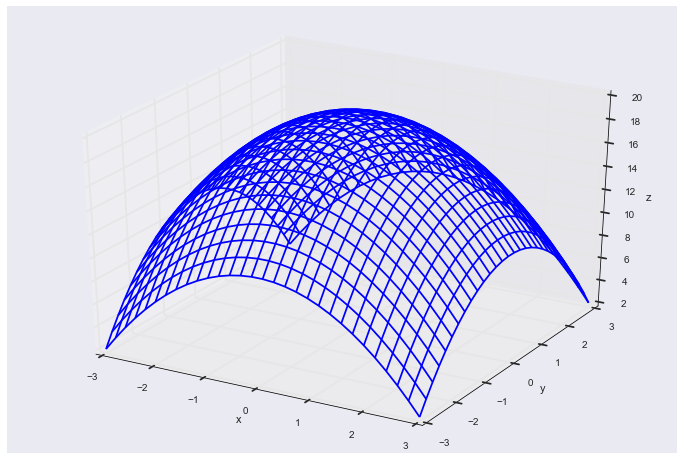

In [374]:
fig = plt.figure(figsize=(12,8))
def f(x, y):
    return 20 - (x ** 2 + y ** 2) 
X, Y = np.meshgrid(np.linspace(-3, 3, 30), np.linspace(-3, 3, 30))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, f(X, Y))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [189]:
steps = [('scaler', StandardScaler()),
         ('sgb', GradientBoostingClassifier())]
pipeline = Pipeline(steps)
parameters = [{'sgb__n_estimators': [200], 
               'sgb__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
               'sgb__subsample': [0.5, 0.7, 0.9],
               'sgb__criterion': ['friedman_mse', 'mse'],
               'sgb__max_depth':[5,8,11,14], 
               'sgb__max_features':[4,8,12], 
               'sgb__random_state':[nb_seed]}]
sgb_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
sgb_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 432 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4125 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4786 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5497 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:  3.5mi

GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'sgb__n_estimators': [200], 'sgb__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'sgb__subsample': [0.5, 0.7, 0.9], 'sgb__criterion': ['friedman_mse', 'mse'], 'sgb__max_depth': [5, 8, 11, 14], 'sgb__max_features': [4, 8, 12], 'sgb__random_state': [1234]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [190]:
print("Best CV params", sgb_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(sgb_gs.best_score_))

Best CV params {'sgb__criterion': 'mse', 'sgb__learning_rate': 0.1, 'sgb__max_depth': 8, 'sgb__max_features': 4, 'sgb__n_estimators': 200, 'sgb__random_state': 1234, 'sgb__subsample': 0.7}
Average Accuracy of the best model: 0.812037037037037


From the printout, we can see that the best model uses the following hyperparameter values:
* Criterion: Mean Squared Error
* Learning Rate: 0.1
* Subsample: 0.7
* Max Depth: 8
* Max Features: 4
* Number of Models: 200

In [191]:
grid_clf = sgb_gs
sgb_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'subsample': grid_clf.cv_results_['param_sgb__subsample'], 
                 'n_estimators': grid_clf.cv_results_['param_sgb__n_estimators'],
                 'learning_rate': grid_clf.cv_results_['param_sgb__learning_rate'],
                 'criterion': grid_clf.cv_results_['param_sgb__criterion'], 
                 'max_depth': grid_clf.cv_results_['param_sgb__max_depth'], 
                 'max_features': grid_clf.cv_results_['param_sgb__max_features']} 

map_df = pd.DataFrame(sgb_grid_dict)

#### Hyperparameter Performance

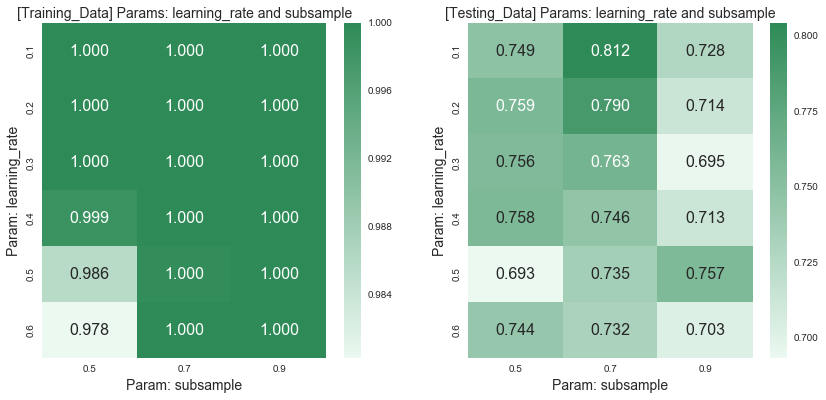

In [195]:
# Looking at variation over subsample and learning_rate 
# with criterion, max_depth, and max_features set to best values
tmp = map_df[(map_df['criterion'] == 'mse') & \
             (map_df['max_depth'] == 8) & \
             (map_df['max_features'] == 4)]

train_test_param_map(x_var_='subsample', y_var_='learning_rate', map_df_=tmp)

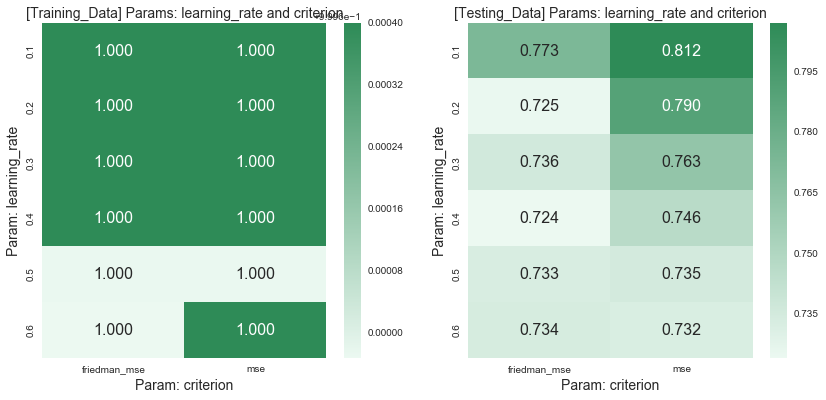

In [196]:
# Looking at variation over criterion and learning_rate 
# with subsample, max_depth, and max_features set to best values
tmp = map_df[(map_df['subsample'] == 0.7) & \
             (map_df['max_depth'] == 8) & \
             (map_df['max_features'] == 4)]

train_test_param_map(x_var_='criterion', y_var_='learning_rate', map_df_=tmp)

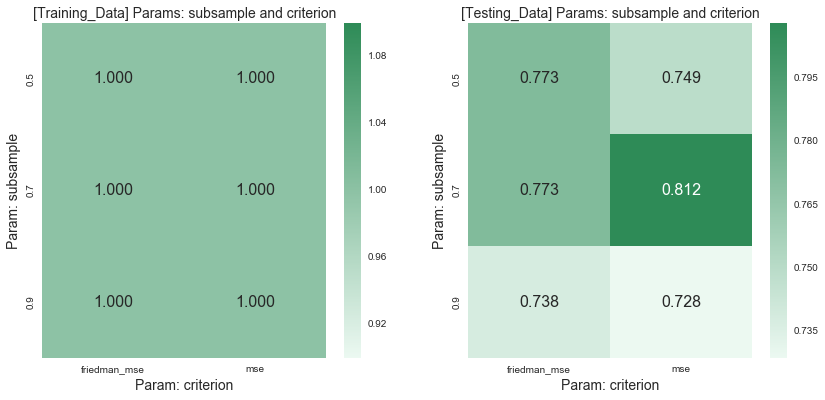

In [197]:
# Looking at variation over criterion and subsample 
# with learning_rate, max_depth, and max_features set to best values
tmp = map_df[(map_df['learning_rate'] == 0.1) & \
             (map_df['max_depth'] == 8) & \
             (map_df['max_features'] == 4)]

train_test_param_map(x_var_='criterion', y_var_='subsample', map_df_=tmp)

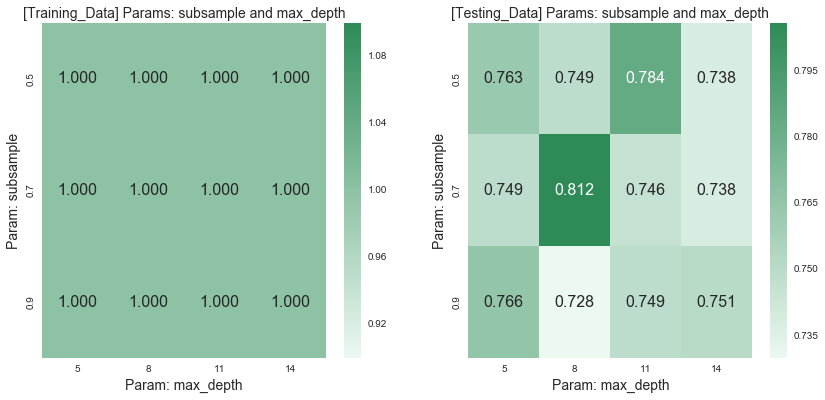

In [198]:
# Looking at variation over max_depth and subsample 
# with learning_rate, criterion, and max_features set to best values
tmp = map_df[(map_df['learning_rate'] == 0.1) & \
             (map_df['criterion'] == 'mse') & \
             (map_df['max_features'] == 4)]

train_test_param_map(x_var_='max_depth', y_var_='subsample', map_df_=tmp)

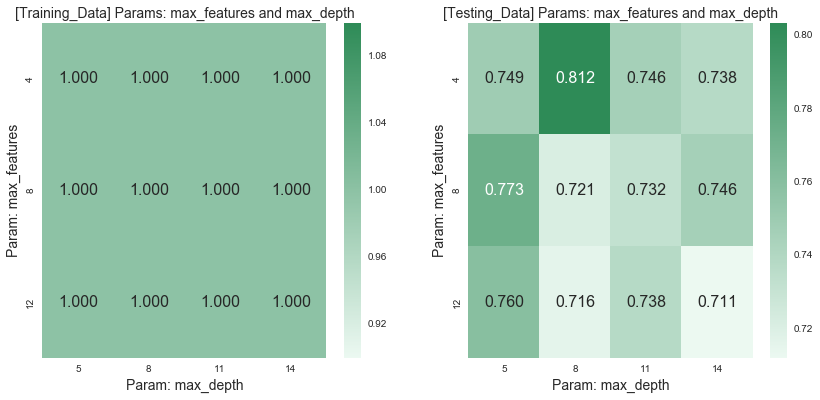

In [199]:
# Looking at variation over max_depth and max_features
# with learning_rate, criterion, and max_features set to best values
tmp = map_df[(map_df['learning_rate'] == 0.1) & \
             (map_df['criterion'] == 'mse') & \
             (map_df['subsample'] == 0.7)]

train_test_param_map(x_var_='max_depth', y_var_='max_features', map_df_=tmp)

In [200]:
print('Best accuracy: {:0.3f}%'.format(ada_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(ada_gs.best_params_))

Best accuracy: 81.204%
Best parameter(s): {'ada__algorithm': 'SAMME', 'ada__base_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'ada__learning_rate': 0.1, 'ada__n_estimators': 100}


The confusion matrices below are for the **Stochastic Gradient Boosting Classifier** with above parameters, was trained with **unnormalized** data, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.83$ unhealthy people as being healthy, and this model labeled $3.50$ healthy people as unhealthy.

Worse than average overall.

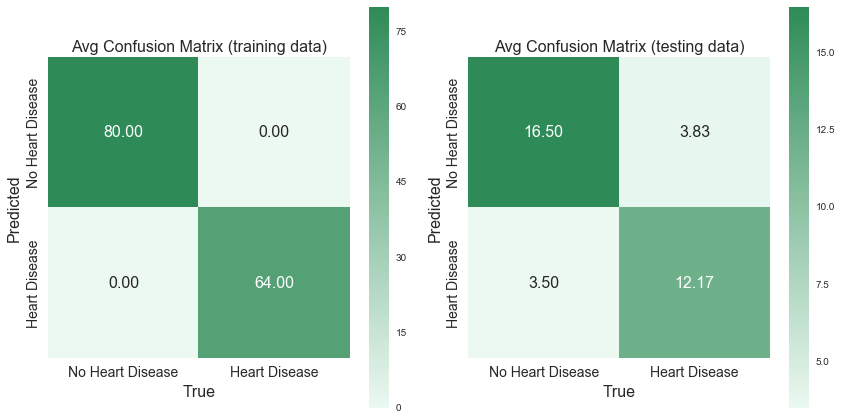

In [201]:
cross_validated_cm_generator(clf_=sgb_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Multilayer Perceptron (a Neural Network) <a id="nn"></a>

**Neural Networks** are yet another distinct class of classifier. Neural Networks mimic the biological neural networks that constitute our brains by building rich networks of neurons that can be activated by input data. Neural networks consist of many hidden layers of neurons and if the signal isn't strong enough at specific nodes, then they don't transmit any signal at all. This allows neural networks to produce complex, non-linear models for observed phenomena, and update these models through a backpropagation process. 

Neural networks are among the most powerful kinds of classifiers, and the Tensorflow, Keras, and Theano packages provide far more support for neural networks than sklearn.

In [202]:
steps = [('scaler', StandardScaler()),
         ('nn', MLPClassifier())]
pipeline = Pipeline(steps)
parameters = [{'nn__hidden_layer_sizes': [(10,),(20,),(40,)], 
               'nn__activation':['identity', 'logistic', 'tanh', 'relu'], 
               'nn__solver': ['lbfgs', 'sgd','adam'],
               'nn__alpha': [0.00001, 0.0001, 0.001, 0.01],
               'nn__learning_rate':['constant','invscaling','adaptive'], 
               'nn__random_state':[nb_seed]}]
nn_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
nn_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 432 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 1233 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1771 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 2409 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3143 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4022 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5982 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 7108 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 8198 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 9520 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 10942 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 12020 tasks      | elapsed:  6

GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nn', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'nn__hidden_layer_sizes': [(10,), (20,), (40,)], 'nn__activation': ['identity', 'logistic', 'tanh', 'relu'], 'nn__solver': ['lbfgs', 'sgd', 'adam'], 'nn__alpha': [1e-05, 0.0001, 0.001, 0.01], 'nn__learning_rate': ['constant', 'invscaling', 'adaptive'], 'nn__random_state': [1234]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [203]:
print("Best CV params", nn_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(nn_gs.best_score_))

Best CV params {'nn__activation': 'logistic', 'nn__alpha': 1e-05, 'nn__hidden_layer_sizes': (20,), 'nn__learning_rate': 'invscaling', 'nn__random_state': 1234, 'nn__solver': 'sgd'}
Average Accuracy of the best model: 1.0


From the printout, we can see that the best model uses the following hyperparameter values:
* Hidden Layer Sizes: (20,)
* Solver: Stochastic Gradient Descent
* Activation Function: Logistic
* Learning Rate: Inverse Scaling
* Alpha: 0.00001

In [204]:
grid_clf = nn_gs
nn_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'hidden_layer_sizes': grid_clf.cv_results_['param_nn__hidden_layer_sizes'], 
                 'activation': grid_clf.cv_results_['param_nn__activation'],
                 'solver': grid_clf.cv_results_['param_nn__solver'],
                 'alpha': grid_clf.cv_results_['param_nn__alpha'], 
                 'learning_rate': grid_clf.cv_results_['param_nn__learning_rate']} 

map_df = pd.DataFrame(nn_grid_dict)

#### Hyperparameter Performance

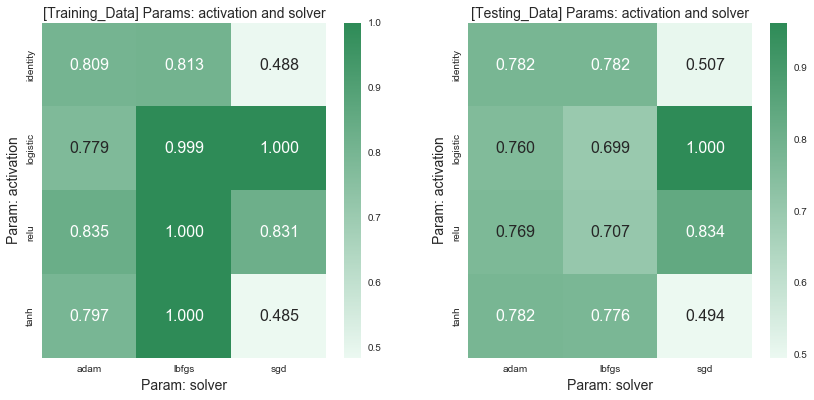

In [205]:
# Looking at variation over Solver and Activation Function 
# with hidden_layer_sizes, alpha, and learning_rate set to best values
tmp = map_df[(map_df['hidden_layer_sizes'] == (20,)) & \
             (map_df['alpha'] == 0.00001) & \
             (map_df['learning_rate'] == 'invscaling')]

train_test_param_map(x_var_='solver', y_var_='activation', map_df_=tmp)

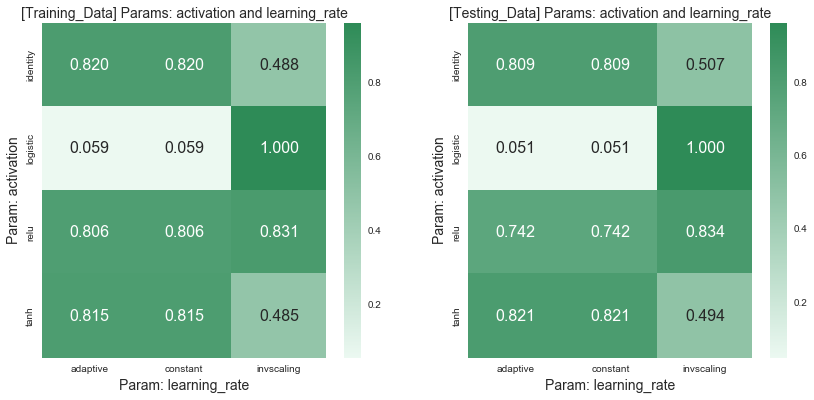

In [206]:
# Looking at variation over Learning Rate and Activation Function 
# with hidden_layer_sizes, alpha, and solver set to best values
tmp = map_df[(map_df['hidden_layer_sizes'] == (20,)) & \
             (map_df['alpha'] == 0.00001) & \
             (map_df['solver'] == 'sgd')]

train_test_param_map(x_var_='learning_rate', y_var_='activation', map_df_=tmp)

In [207]:
print('Best accuracy: {:0.3f}%'.format(nn_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(nn_gs.best_params_))

Best accuracy: 100.000%
Best parameter(s): {'nn__activation': 'logistic', 'nn__alpha': 1e-05, 'nn__hidden_layer_sizes': (20,), 'nn__learning_rate': 'invscaling', 'nn__random_state': 1234, 'nn__solver': 'sgd'}


The best recall score is 100%, that's pretty incredible! However, looking at the confusion matrices, we see what happened. Recall is defined as $\frac{TP}{TP + FN}$, and the neural network chose a very simple rule to achieve this; always predict heart disease. While this doesn't make any of the costly error, it's if a doctor simply diagnosed every single patient as having heart disease, that doctor would quickly lose credibility. 

I'll run this again, but this time, I'll use a different scoring metric.

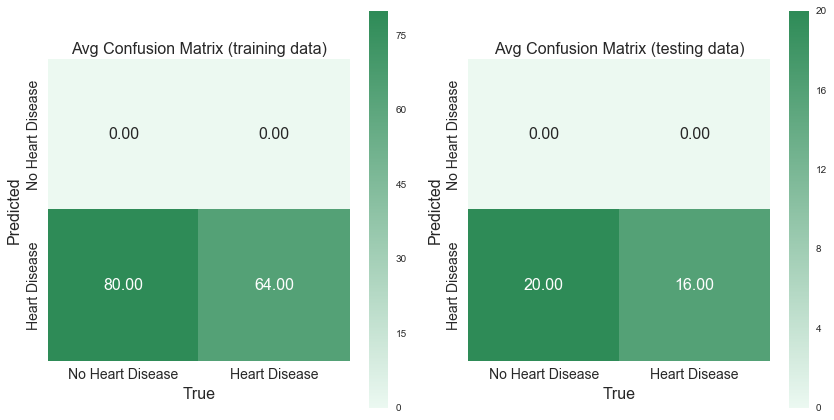

In [208]:
cross_validated_cm_generator(clf_=nn_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Multilayer Perceptron (a Neural Network) <a id="nn_scored"></a>

In [220]:
steps = [('scaler', StandardScaler()),
         ('nn', MLPClassifier())]
pipeline = Pipeline(steps)
parameters = [{'nn__hidden_layer_sizes': [(20,),(40,),(60,)], 
               'nn__activation':['identity', 'logistic', 'tanh', 'relu'], 
               'nn__solver': ['lbfgs', 'sgd','adam'],
               'nn__alpha': [0.001, 0.01],
               'nn__learning_rate':['constant','invscaling','adaptive'], 
               'nn__random_state':[nb_seed]}]
nn_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='f1', n_jobs=-1, verbose=4)
nn_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 216 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 463 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 929 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1371 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4111 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4867 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  3.6min finished
C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_i

GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nn', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'nn__hidden_layer_sizes': [(20,), (40,), (60,)], 'nn__activation': ['identity', 'logistic', 'tanh', 'relu'], 'nn__solver': ['lbfgs', 'sgd', 'adam'], 'nn__alpha': [0.001, 0.01], 'nn__learning_rate': ['constant', 'invscaling', 'adaptive'], 'nn__random_state': [1234]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=4)

In [221]:
print("Best CV params", nn_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(nn_gs.best_score_))

Best CV params {'nn__activation': 'logistic', 'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (40,), 'nn__learning_rate': 'constant', 'nn__random_state': 1234, 'nn__solver': 'adam'}
Average Accuracy of the best model: 0.8067724867724867


From the printout, we can see that the best model uses the following hyperparameter values:
* Hidden Layer Sizes: (40,)
* Solver: Adam
* Activation Function: logistic
* Learning Rate: constant
* Alpha: 0.00001

In [222]:
grid_clf = nn_gs
nn_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'hidden_layer_sizes': grid_clf.cv_results_['param_nn__hidden_layer_sizes'], 
                 'activation': grid_clf.cv_results_['param_nn__activation'],
                 'solver': grid_clf.cv_results_['param_nn__solver'],
                 'alpha': grid_clf.cv_results_['param_nn__alpha'], 
                 'learning_rate': grid_clf.cv_results_['param_nn__learning_rate']} 

map_df = pd.DataFrame(nn_grid_dict)

#### Hyperparameter Performance

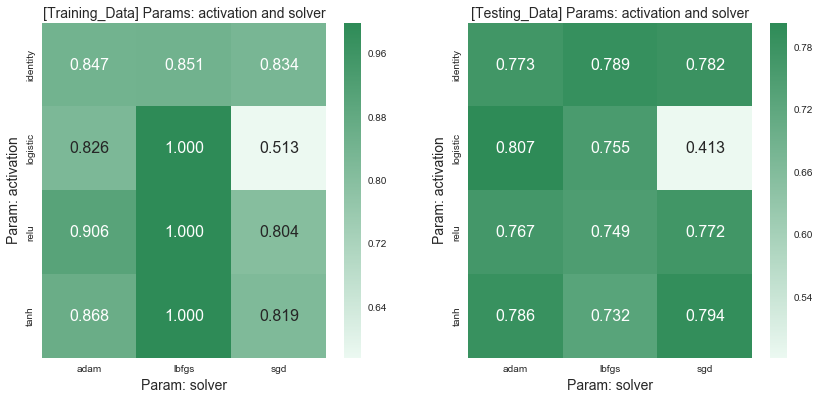

In [225]:
# Looking at variation over Solver and Activation Function 
# with hidden_layer_sizes, alpha, and learning_rate set to best values
tmp = map_df[(map_df['hidden_layer_sizes'] == (40,)) & \
             (map_df['alpha'] == 0.001) & \
             (map_df['learning_rate'] == 'constant')]

train_test_param_map(x_var_='solver', y_var_='activation', map_df_=tmp)

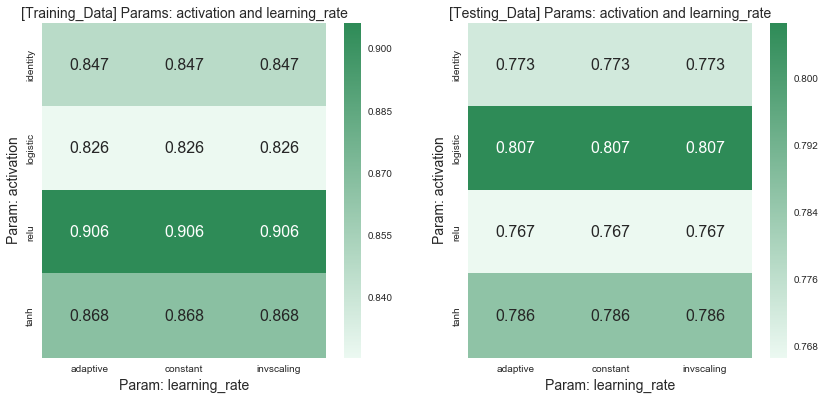

In [226]:
# Looking at variation over Learning Rate and Activation Function 
# with hidden_layer_sizes, alpha, and solver set to best values
tmp = map_df[(map_df['hidden_layer_sizes'] == (40,)) & \
             (map_df['alpha'] == 0.001) & \
             (map_df['solver'] == 'adam')]

train_test_param_map(x_var_='learning_rate', y_var_='activation', map_df_=tmp)

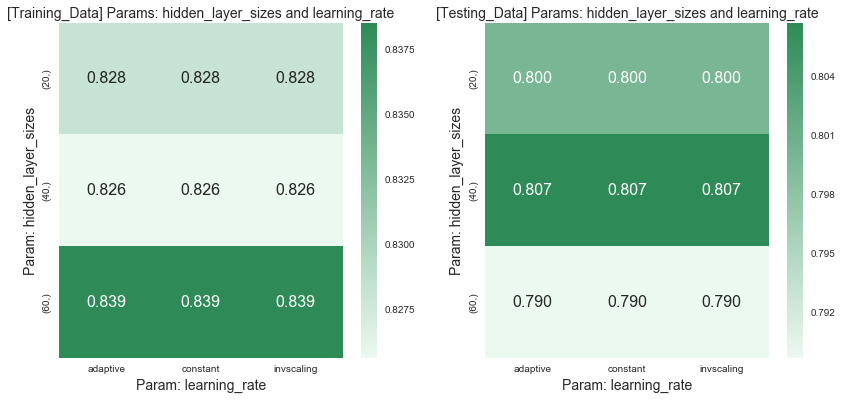

In [227]:
# Looking at variation over Learning Rate and hidden_layer_sizes 
# with hidden_layer_sizes, alpha, and solver set to best values
tmp = map_df[(map_df['activation'] == 'logistic') & \
             (map_df['alpha'] == 0.001) & \
             (map_df['solver'] == 'adam')]

train_test_param_map(x_var_='learning_rate', y_var_='hidden_layer_sizes', map_df_=tmp)

Ok, we see no variance across different numbers of hidden layers or learning rates, given best other parameters.

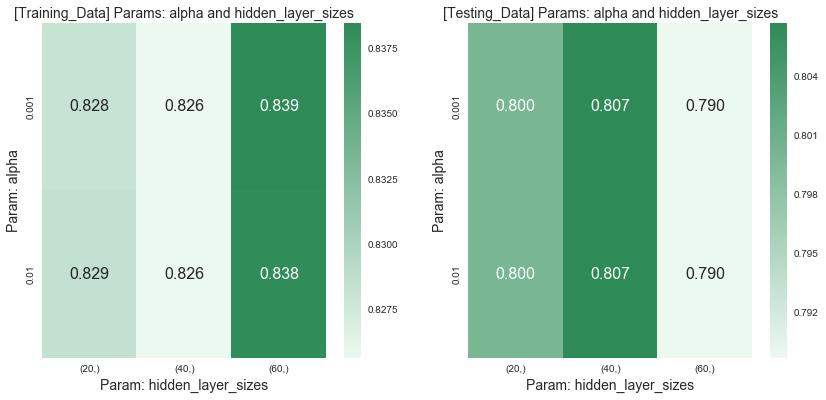

In [228]:
# Looking at variation over Alpha and hidden_layer_sizes 
# with hidden_layer_sizes, alpha, and solver set to best values
tmp = map_df[(map_df['activation'] == 'logistic') & \
             (map_df['learning_rate'] == 'constant') & \
             (map_df['solver'] == 'adam')]

train_test_param_map(x_var_='hidden_layer_sizes', y_var_='alpha', map_df_=tmp)

We also see no variance across different numbers of hidden layers or alpha, given best other parameters.

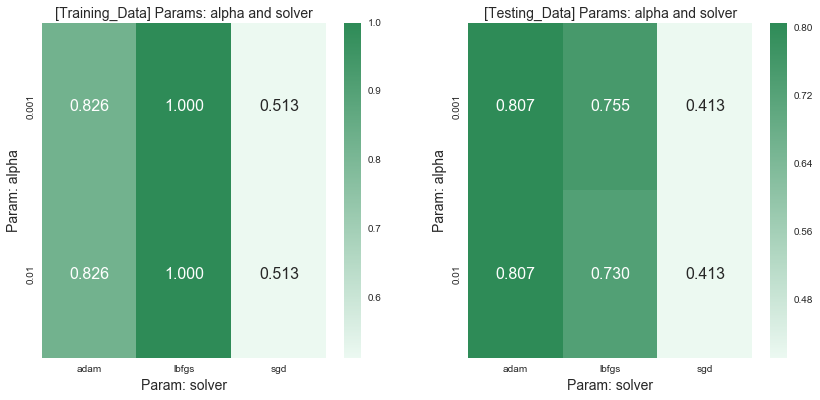

In [229]:
# Looking at variation over Alpha and solver 
# with hidden_layer_sizes, alpha, and solver set to best values
tmp = map_df[(map_df['activation'] == 'logistic') & \
             (map_df['learning_rate'] == 'constant') & \
             (map_df['hidden_layer_sizes'] == (40,))]

train_test_param_map(x_var_='solver', y_var_='alpha', map_df_=tmp)

In [230]:
print('Best accuracy: {:0.3f}%'.format(nn_gs.best_score_ * 100))
print('Best parameter(s): {}'.format(nn_gs.best_params_))

Best accuracy: 80.677%
Best parameter(s): {'nn__activation': 'logistic', 'nn__alpha': 0.001, 'nn__hidden_layer_sizes': (40,), 'nn__learning_rate': 'constant', 'nn__random_state': 1234, 'nn__solver': 'adam'}


We're using a differnt measure now, **f1**, which is the harmonic average of the **recall score** and **precision score**, so we can't directly compare it to prior runs, but we can still compare the confusion matrices values. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.40$ unhealthy people as being healthy, and this model labeled $2.97$ healthy. 

This is above average.

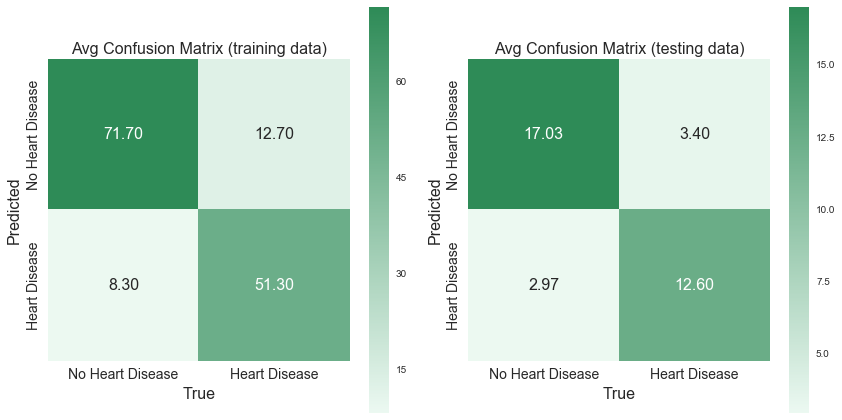

In [234]:
%%capture --no-display
cross_validated_cm_generator(clf_=nn_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

## Voting Classifier <a id="voting"></a>

As you can see from the summary table below, the best classifier so far has been a simple Logistic Regression classifier. None of the classifiers have achieved a recall score above 85%.

Each of these different machine learning algorithms has a slightly different bias and may make different misclassifications. To smooth out this effect, the final classifier I'll explore is the **Voting Classifier** which trains a number of different kinds of classifiers, uses those different classifiers to make predictions about data, and treats those predictions as votes.


## Performance Summary of Prior Classifiers <a id="performance"></a>

| Base Classifier | Best Parameters | Scaling | Recall Score | False Negative Avg | False Positive Avg |
| --------------- | --------------- | ------- | ------------ | ------------------ | ------------------ |
| Logistic Regression | C: 0.0001, penalty: L2 | yes | 0.7982 | 3.17 | 4.00 |
| SVC | C: 100, gamma: 0.01, kernel: rbf | yes | 0.7954 | 3.97 | 4.17 |
| Decision Tree | Criterion: Gini, max_depth: 5, min_samples_leaf: 1 | no | 0.7333 | 5.10 | 4.50 |
| K Nearest Neighbors | n_neighbors: 9, weights: uniform, metric: Manhattan | yes | 0.8222 | 3.23 | 3.37 |
| Naive Bayes | alpha: <= 1 | yes | 0.7963 | 3.17 | 3.93 |
| Naive Bayes | alpha: 10 | no | 0.7963 | 3.30 | 3.60 |
| Random Forest | Criterion: Gini, max_depth: 11, min_samples_leaf: 3, max_features: 6 | no | 0.7741 | 3.67 | 3.47 |
| AdaBoost | Algorithm: SAMME.R, base estimator: Naive Bayes, learning_rate: 0.1 | no | 0.7972 | 3.03 | 2.97 |
| AdaBoost | Algorithm: SAMME, base estimator: Logistic Regression, learining_rate: 0.1 | yes | 0.8120 | 3.13 | 3.17 |
| Stochastic Gradient Boosting | Criterion: MSE, learning_rate: 0.1, subsample: 0.7, max_depth: 8, max_features: 4 | yes | 0.8120 | 3.83 | 3.50 |
| Neural Network | activation: logistic, alpha: 0.001, hidden_layer_sizes: (40,), learning_rate: constant, solver: adam | yes | 0.8068 | 3.40 | 2.97 |

In [235]:
logreg = LogisticRegression(C=0.0001, penalty='l2')
svm = SVC(C=100, gamma=0.01, kernel='rbf', probability=True)
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=1)
knn = KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='manhattan')
bnb_s = BernoulliNB(alpha=1)
bnb = BernoulliNB(alpha=10)
rf = RandomForestClassifier(criterion='gini',max_depth=11, min_samples_leaf=3, max_features=6)
ada = AdaBoostClassifier(algorithm='SAMME.R',base_estimator=BernoulliNB(), learning_rate=0.1)
ada_s = AdaBoostClassifier(algorithm='SAMME', base_estimator=LogisticRegression(), learning_rate=0.1)
sgb = GradientBoostingClassifier(criterion='mse', learning_rate=0.1, subsample=0.7, max_depth=8, max_features=4)
nn = MLPClassifier(activation='logistic', hidden_layer_sizes=(40,), learning_rate='constant', solver='adam', alpha=0.001)

In [236]:
clfs_w_scaling = [('logreg', logreg), 
                  ('svm', svm), 
                  ('knn', knn), 
                  ('bnb_s', bnb_s),
                  ('ada_s', ada_s), 
                  ('sgb', sgb), 
                  ('nn', nn)]
clfs_w_o = [('dt', dt), 
            ('bnb', bnb), 
            ('rf', rf), 
            ('ada', ada)]

### Voting Classifier with Unscaled Data <a id="voting_unscaled"></a>

In [237]:
steps = [('vc', VotingClassifier(estimators=clfs_w_o))]
pipeline = Pipeline(steps)
parameters = [{'vc__voting':['hard','soft']}]
vc_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
vc_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.7s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vc', VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
        ...=50, random_state=None))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vc__voting': ['hard', 'soft']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [238]:
print("Best CV params", vc_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(vc_gs.best_score_))

Best CV params {'vc__voting': 'soft'}
Average Accuracy of the best model: 0.7740740740740739


From the printout, we can see that the voting classifier model uses soft voting, which takes predicted probabilities into account rather than just using hard voting.

In [239]:
grid_clf = vc_gs
vc_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'voting': grid_clf.cv_results_['param_vc__voting']} 

map_df = pd.DataFrame(vc_grid_dict)

#### Hyperparameter Performance

In [240]:
map_df

mean_train_score  mean_test_score voting
0          0.808625         0.746296   hard
1          0.867288         0.774074   soft

The confusion matrices below are for the **Voting Classifier** consisting of all prior classifiers that used **unnormalized** data, used **soft voting**, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.70$ unhealthy people as being healthy, and this model labeled $3.47$ healthy.

This is a rather underwhelming classifier.

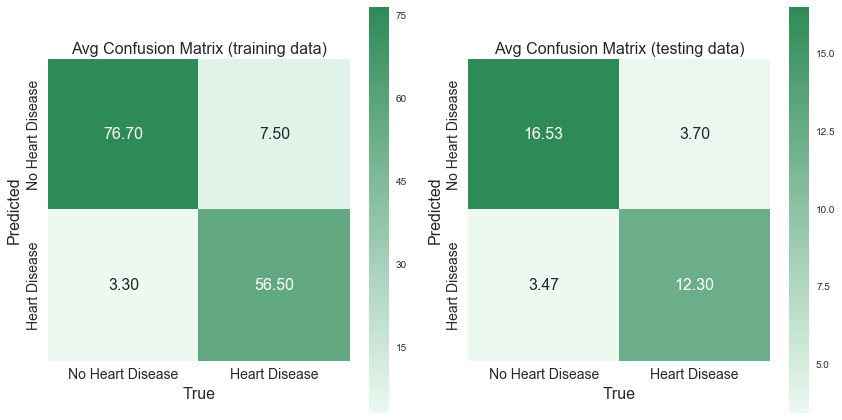

In [241]:
cross_validated_cm_generator(clf_=vc_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Voting Classifier with Scaled Data <a id="voting_scaled"></a>

In [242]:
steps = [('scaler', StandardScaler()),
         ('vc', VotingClassifier(estimators=clfs_w_scaling))]
pipeline = Pipeline(steps)
parameters = [{'vc__voting':['hard','soft']}]
vc_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
vc_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   13.8s finished
C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vc', VotingClassifier(estimators=[('logreg', LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2'...alse, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vc__voting': ['hard', 'soft']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [243]:
print("Best CV params", vc_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(vc_gs.best_score_))

Best CV params {'vc__voting': 'hard'}
Average Accuracy of the best model: 0.812037037037037


From the printout, we can see that the voting classifier model uses hard voting, which simply tallies votes even if the predicted probability is just barely over 50%.

In [244]:
grid_clf = vc_gs
vc_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'voting': grid_clf.cv_results_['param_vc__voting']} 

map_df = pd.DataFrame(vc_grid_dict)

#### Hyperparameter Performance

In [245]:
map_df

mean_train_score  mean_test_score voting
0          0.820258         0.812037   hard
1          0.873687         0.798148   soft

The confusion matrices below are for the **Voting Classifier** consisting of all prior classifiers that used **normalized** data, used **soft voting**, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.10$ unhealthy people as being healthy, and this model labeled $3.50$ healthy.

Regarding false negatives, this is the 2nd best classifier to this point. 

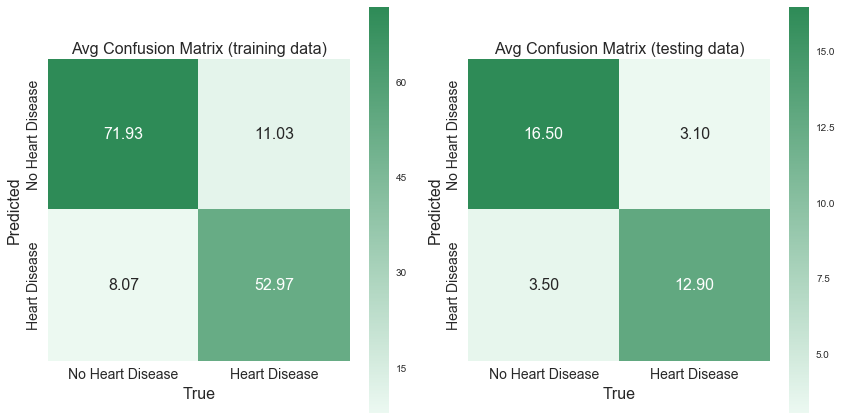

In [247]:
%%capture --no-display
cross_validated_cm_generator(clf_=vc_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

### Voting Classifier with Scaled Data (3 Best Classifiers) <a id="voting_3best"></a>

In [248]:
best_clfs = [('logreg', logreg),
             ('bnb', bnb),
             ('ada_s', ada_s)]

In [250]:
steps = [('scaler', StandardScaler()),
         ('vc', VotingClassifier(estimators=best_clfs))]
pipeline = Pipeline(steps)
parameters = [{'vc__voting':['hard','soft']}]
vc_gs = GridSearchCV(pipeline, parameters, cv=30, return_train_score=True, scoring='recall', n_jobs=-1, verbose=4)
vc_gs.fit(X_train, y_train.values.reshape((y_train.size,)))

Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.2s finished


GridSearchCV(cv=30, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('vc', VotingClassifier(estimators=[('logreg', LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2'...=50, random_state=None))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vc__voting': ['hard', 'soft']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=4)

In [252]:
print("Best CV params", vc_gs.best_params_)
print('Average Accuracy of the best model: {}'.format(vc_gs.best_score_))

Best CV params {'vc__voting': 'hard'}
Average Accuracy of the best model: 0.812037037037037


From the printout, we can see that the voting classifier model uses hard voting

In [253]:
grid_clf = vc_gs
vc_grid_dict = {'mean_train_score': grid_clf.cv_results_['mean_train_score'],
                 'mean_test_score': grid_clf.cv_results_['mean_test_score'], 
                 'voting': grid_clf.cv_results_['param_vc__voting']} 

map_df = pd.DataFrame(vc_grid_dict)

#### Hyperparameter Performance

In [254]:
map_df

mean_train_score  mean_test_score voting
0          0.811200         0.812037   hard
1          0.808603         0.796296   soft

The confusion matrices below are for the **Voting Classifier** consisting of the 3 best prior classifiers that used **normalized** data, used **hard voting**, and used parameters that were selected by the **recall** scoring measure rather than simple accuracy. Over the 30 runs and over a sample of 35 people, this model labeled (on average) $3.07$ unhealthy people as being healthy, and this model labeled $3.90$ healthy.

Regarding false negatives, this is the 2nd best classifier to this point (beating the earlier voting classifier that took 2nd), but it produced more false positives than most other classifiers. Pretty excellent!

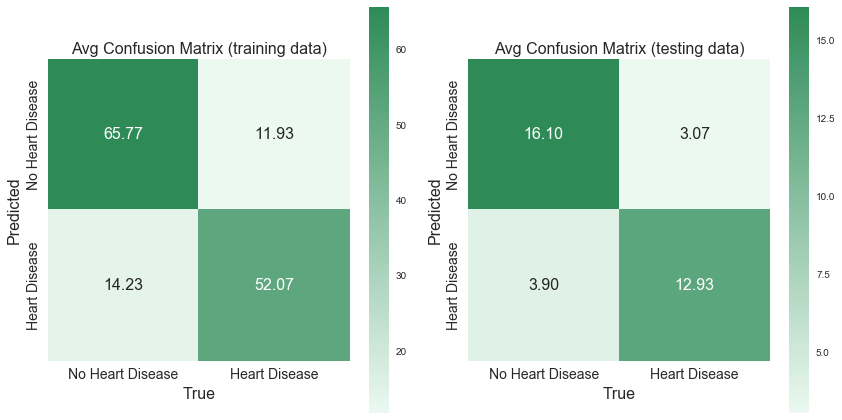

In [255]:
cross_validated_cm_generator(clf_=vc_gs.best_estimator_, 
                             X_train_=X_train,
                             y_train_=y_train.values.reshape((len(y_train),)), 
                             class_labels=['No Heart Disease', 'Heart Disease'], 
                             n_splits_=5, 
                             n_reps_=6, 
                             labels=[0,1])

# Final Observations <a id="final"></a>

After all of those classifiers, we found the best performance was observed AdaBoost classifier. We can reliably catch approximately 79% of all cases of Heart Disease based only on data, which is far better than random. I chose a fairly small data set for this notebook so that I could quickly prototype through a large number of classifiers and showcase the robust set of tools in the sklearn toolbox.

In this notebook, we've:
* Visually explored the raw data
* Preprocessed the data into a format suitable for machine learning
* Built pipelines to ensure data used for model validation isn't used in training
* Produced simple classifiers, 
    * diagnosed problems with those classifiers, 
    * improved classifier performance by adjusting preprocessing steps, hyperparameters, and scoring metrics
* Interpreted classifier outputs and visually presented interpretable features